In [1]:
import os
import random
import copy
import math
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import gc
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset

In [2]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

mps


# param setting

In [15]:
EPOCHS = 500
LR = 1e-3
BS = 16
SEED = 42
WINDOW_SIZE = 8
KERNEL_SIZE = 5
STRIDE = 1
MODEL_NAME ='conv1d_model_type'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(SEED) # Seed 고정

# Data loading

In [5]:
train_df = pd.read_csv('./dataset/train_data.csv')
test_df = pd.read_csv('./dataset/test_data.csv')

# Data scaling

In [6]:
train_each_list = []
train_each_list.append(train_df.loc[train_df['type']==0])
train_each_list.append(train_df.loc[train_df['type']==1])
train_each_list.append(train_df.loc[train_df['type']==2])
train_each_list.append(train_df.loc[train_df['type']==3])
train_each_list.append(train_df.loc[train_df['type']==4])
train_each_list.append(train_df.loc[train_df['type']==5])
train_each_list.append(train_df.loc[train_df['type']==6])
train_each_list.append(train_df.loc[train_df['type']==7])

In [7]:
def making_model_input(x):
    s_size = WINDOW_SIZE
    x = np.array(x)
    data = []
    cnt = x.shape[0]-s_size+1
    for i in range(0,cnt,STRIDE):
        tmp = x[i:i+s_size][:]
        #tmp = tmp - np.mean(tmp,axis=0)
        data.append(tmp)
    return np.array(data)

In [8]:
def making_2d(x):
    s_Size = WINDOW_SIZE
    x = np.array(x)
    data = []
    for i in range(x.shape[0]):
        data.append(x[i][0][:])
    for i in range(x.shape[1]-1):
        data.append(x[x.shape[0]-1][i][:])
    result = np.array(data)
    return(result)


# Make custom dataset

In [9]:
class MyDataset(Dataset):
    def __init__(self, origin_x):
        self.data = origin_x
        
    def __getitem__(self, index):
        self.x = self.data[index]
        return torch.Tensor(self.x)

    def __len__(self):
        return len(self.data)

#Pytorch를 사용하기 위해 custom dataset 구성해줌

In [ ]:
# Autoencoder model using fully connect layer, dropout, batchnorm1d, he_normal

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self,in_features):
        super(AutoEncoder, self).__init__()
        self.feature_num = in_features
        self.Encoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=in_features, out_channels=16, kernel_size=KERNEL_SIZE, stride=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=KERNEL_SIZE, stride=1),
            nn.ReLU(),
        )
        self.Decoder = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=KERNEL_SIZE,stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=in_features, kernel_size=KERNEL_SIZE,stride=1),
        )
        self.init_weight()

    def forward(self, x):
        encoded = self.Encoder(x)
        decoded = self.Decoder(encoded)
        return decoded, encoded

    def init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.ConvTranspose1d):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
  

In [12]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.MSELoss().to(self.device)
        
    def fit(self, index):
        self.model.to(self.device)
        best_loss = 1000000000
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            i = 1
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()
                _x,_ = self.model(x)
                loss = self.criterion(x,_x)
                loss.backward()
                self.optimizer.step()
                train_loss.append(loss.item())
                i=i+1
                
            val_loss, true, pred= self.validation(self.model)
            
            true_2d = making_2d(true)
            pred_2d = making_2d(pred)
            
            error = true_2d - pred_2d
            mse = np.mean(np.power(error,2),axis=1)
            
            mean_train_loss = np.mean(train_loss)
            
            print(f'Epoch : [{epoch+1}] Train loss : [{mean_train_loss}] val loss : [{val_loss}]\n')
            
            self.scheduler.step(val_loss)
            
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model, './' + MODEL_NAME+str(index)+'.pth')
                #print("Save Model~_~")
        
        print(best_loss)
        return best_loss * 5
    
    def validation(self, eval_model):
        eval_model.eval()
        val_loss = []
        true = []
        pred = []
        with torch.no_grad():
            for x in iter(self.val_loader):
                pred_tmp = []
                x = x.float().to(self.device)
                _x,_ = eval_model(x)
                #print(mse.shape)
                loss = self.criterion(x,_x)
                val_loss.append(loss.item())
                true += x.detach().tolist()
                pred += _x.detach().tolist()
        
        return np.mean(val_loss), true, pred

# fit

In [13]:
scaler_list = []
mean_loss_list = []
for i in range(8):
    train_data = train_each_list[i]
    train_data = train_data.loc[train_data['motor_vibe'] < 10]
    train_data_drop = train_data.drop('type', axis=1)
    train_x, val_x = train_test_split(train_data_drop, test_size = 0.1, random_state=SEED, shuffle=False)
    
    print(i)
    scaler = StandardScaler()
    train_x = scaler.fit_transform(np.array(train_x))
    val_x = scaler.transform(np.array(val_x))
    scaler_list.append(scaler)
    
    train_dataset = MyDataset(making_model_input(train_x))
    train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=False)
    val_dataset = MyDataset(making_model_input(val_x))
    val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)
    
    it = iter(train_loader)
    in_features = next(it)[0].shape[0]
    
    gc.collect()

    seed_everything(SEED) # Seed 고정 (모델 생성전에 다시 고정하였더니 재현이 똑같이됨..
    model = AutoEncoder(in_features)
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = LR,weight_decay=1e-1)#Opimizer : AdamW
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, threshold = 1e-8, threshold_mode='abs', min_lr=1e-8, verbose=True)
    trainer = Trainer(model, optimizer, train_loader, val_loader, scheduler, device)
    #trainer 객체 생성
    mean_loss_list.append(trainer.fit(i))

0
Epoch : [1] Train loss : [0.767490416765213] val loss : [0.6373513142267863]

Epoch : [2] Train loss : [0.5223603310684363] val loss : [0.39910510182380676]

Epoch : [3] Train loss : [0.30675009700159234] val loss : [0.24173333744208017]

Epoch : [4] Train loss : [0.20320704393088818] val loss : [0.17466268440087637]

Epoch : [5] Train loss : [0.15814747816572586] val loss : [0.14158443113168082]

Epoch : [6] Train loss : [0.1318075144663453] val loss : [0.11881967633962631]

Epoch : [7] Train loss : [0.11272856841484706] val loss : [0.1023714616894722]

Epoch : [8] Train loss : [0.09829712938517332] val loss : [0.09035186966260274]

Epoch : [9] Train loss : [0.08676581426213185] val loss : [0.08057315150896709]

Epoch : [10] Train loss : [0.07690559964006145] val loss : [0.07234405726194382]

Epoch : [11] Train loss : [0.06846237570668261] val loss : [0.06528457999229431]

Epoch : [12] Train loss : [0.06132526183500886] val loss : [0.05931289866566658]

Epoch : [13] Train loss : [0.

Epoch : [101] Train loss : [0.006167296223187198] val loss : [0.006443326206256946]

Epoch : [102] Train loss : [0.005739304334080468] val loss : [0.006230753691246112]

Epoch : [103] Train loss : [0.0057723142866355675] val loss : [0.00653701089322567]

Epoch : [104] Train loss : [0.005719221332886566] val loss : [0.0064202770590782166]

Epoch : [105] Train loss : [0.005583740440973391] val loss : [0.0065648228240509825]

Epoch : [106] Train loss : [0.005541870428714901] val loss : [0.0064134057611227036]

Epoch : [107] Train loss : [0.00537787326417553] val loss : [0.006390385174502929]

Epoch : [108] Train loss : [0.005292905058013275] val loss : [0.006073050511380036]

Epoch : [109] Train loss : [0.005167999498856564] val loss : [0.005926793984447916]

Epoch : [110] Train loss : [0.005068674673869585] val loss : [0.00581784484287103]

Epoch : [111] Train loss : [0.004974379146005958] val loss : [0.005715215190624197]

Epoch : [112] Train loss : [0.004900057829217985] val loss : [0.

Epoch : [197] Train loss : [0.002737906421922768] val loss : [0.0036796987211952605]

Epoch : [198] Train loss : [0.002721308386147333] val loss : [0.0026963434259717665]

Epoch : [199] Train loss : [0.002500842344791939] val loss : [0.002792525105178356]

Epoch : [200] Train loss : [0.0023685605944289514] val loss : [0.002290021744556725]

Epoch : [201] Train loss : [0.002320378232980147] val loss : [0.002990831776211659]

Epoch : [202] Train loss : [0.002270097359238813] val loss : [0.0024821157955254116]

Epoch : [203] Train loss : [0.0025064302171813324] val loss : [0.003057439384671549]

Epoch : [204] Train loss : [0.002795854127422596] val loss : [0.002722818055190146]

Epoch : [205] Train loss : [0.0025480483018327504] val loss : [0.003160143542724351]

Epoch : [206] Train loss : [0.0023397864958193773] val loss : [0.0024745149227480092]

Epoch : [207] Train loss : [0.0022790762789857886] val loss : [0.0026381416246294975]

Epoch : [208] Train loss : [0.002150336430834917] val l

Epoch : [293] Train loss : [0.000993753058234385] val loss : [0.0013741851241017382]

Epoch : [294] Train loss : [0.0009839682364448283] val loss : [0.0013773555401712656]

Epoch : [295] Train loss : [0.0009765820213942789] val loss : [0.0013587006639378767]

Epoch : [296] Train loss : [0.0009641999859013595] val loss : [0.0013514185945192974]

Epoch : [297] Train loss : [0.0009552389916886265] val loss : [0.0013380617213745911]

Epoch : [298] Train loss : [0.0009450541741292303] val loss : [0.0013269968718911211]

Epoch : [299] Train loss : [0.000934735738458888] val loss : [0.001314063110233595]

Epoch : [300] Train loss : [0.0009255644278406786] val loss : [0.0013037814254251618]

Epoch : [301] Train loss : [0.0009155978623311967] val loss : [0.0012913860264234245]

Epoch : [302] Train loss : [0.0009069814210912833] val loss : [0.0012830070918425918]

Epoch : [303] Train loss : [0.0008978314726846293] val loss : [0.0012725981456848483]

Epoch : [304] Train loss : [0.0008898340444526

Epoch : [387] Train loss : [0.00043795983159119106] val loss : [0.0006941491931987306]

Epoch : [388] Train loss : [0.00043713826077388757] val loss : [0.0006918283567453424]

Epoch : [389] Train loss : [0.0004360408541591217] val loss : [0.0006905516687159737]

Epoch : [390] Train loss : [0.0004352257049807425] val loss : [0.0006880041134233276]

Epoch : [391] Train loss : [0.0004340063721125868] val loss : [0.000686642345196257]

Epoch : [392] Train loss : [0.00043329279045186314] val loss : [0.0006838214370266845]

Epoch : [393] Train loss : [0.000431954100956015] val loss : [0.0006813594275930276]

Epoch : [394] Train loss : [0.0004308504103391897] val loss : [0.0006801942848445227]

Epoch : [395] Train loss : [0.0004299414085835451] val loss : [0.0006772696215193719]

Epoch : [396] Train loss : [0.00042864144112778985] val loss : [0.0006748859110909203]

Epoch : [397] Train loss : [0.0004273056911188178] val loss : [0.0006735774513799697]

Epoch : [398] Train loss : [0.00042638962

Epoch : [481] Train loss : [0.0003042677350701221] val loss : [0.0005594090616796166]

Epoch : [482] Train loss : [0.00030235462994217716] val loss : [0.0005558971606660634]

Epoch : [483] Train loss : [0.000300615686379994] val loss : [0.0005544660671148449]

Epoch : [484] Train loss : [0.00029927385063880746] val loss : [0.0005522271191390852]

Epoch : [485] Train loss : [0.0002974008669601365] val loss : [0.0005500927024210492]

Epoch : [486] Train loss : [0.0002958983150165295] val loss : [0.0005475097665718446]

Epoch : [487] Train loss : [0.00029388473558356054] val loss : [0.0005444546889824172]

Epoch : [488] Train loss : [0.0002921249949091968] val loss : [0.0005420580273494124]

Epoch : [489] Train loss : [0.0002904612162334767] val loss : [0.0005401260568760335]

Epoch : [490] Train loss : [0.0002887928894779179] val loss : [0.000537594974351426]

Epoch : [491] Train loss : [0.0002869086765713291] val loss : [0.0005342571045427272]

Epoch : [492] Train loss : [0.000285143682

Epoch : [79] Train loss : [0.01051019518636167] val loss : [0.013022315688431263]

Epoch : [80] Train loss : [0.010453151585534216] val loss : [0.012932069599628448]

Epoch : [81] Train loss : [0.01037796139717102] val loss : [0.01279459660872817]

Epoch : [82] Train loss : [0.010302686574868858] val loss : [0.012680172454565763]

Epoch : [83] Train loss : [0.010211522690951824] val loss : [0.012542994227260351]

Epoch : [84] Train loss : [0.01012605051510036] val loss : [0.01243524020537734]

Epoch : [85] Train loss : [0.010048089921474457] val loss : [0.012310490477830172]

Epoch : [86] Train loss : [0.009964568843133747] val loss : [0.012226027436554432]

Epoch : [87] Train loss : [0.009891286748461426] val loss : [0.012150676921010017]

Epoch : [88] Train loss : [0.009822954051196575] val loss : [0.01205848017707467]

Epoch : [89] Train loss : [0.009774776548147202] val loss : [0.012012939900159836]

Epoch : [90] Train loss : [0.009791791252791882] val loss : [0.012040351051837206]

Epoch : [177] Train loss : [0.005846784624736756] val loss : [0.006981062702834606]

Epoch : [178] Train loss : [0.005981284903828055] val loss : [0.006907223490998149]

Epoch : [179] Train loss : [0.005828611773904413] val loss : [0.006941804429516196]

Epoch : [180] Train loss : [0.005266329878941179] val loss : [0.00646993750706315]

Epoch : [181] Train loss : [0.004799918120261282] val loss : [0.006403536535799503]

Epoch : [182] Train loss : [0.0045877436874434355] val loss : [0.006370787508785725]

Epoch : [183] Train loss : [0.004564768844284117] val loss : [0.006308631971478462]

Epoch : [184] Train loss : [0.00472297688247636] val loss : [0.0063232132233679295]

Epoch : [185] Train loss : [0.004999841726385057] val loss : [0.006352426717057824]

Epoch : [186] Train loss : [0.0052353421226143835] val loss : [0.006259401561692357]

Epoch : [187] Train loss : [0.005261081270873547] val loss : [0.0061306823045015335]

Epoch : [188] Train loss : [0.0052004244760610165] val loss : [

Epoch : [275] Train loss : [0.0033457484212704005] val loss : [0.004354645381681621]

Epoch : [276] Train loss : [0.0032136178459040822] val loss : [0.004176829126663506]

Epoch : [277] Train loss : [0.0032092419744003562] val loss : [0.003923696232959628]

Epoch : [278] Train loss : [0.0035151977266650648] val loss : [0.00407288852147758]

Epoch : [279] Train loss : [0.003810867218999192] val loss : [0.004477015812881291]

Epoch : [280] Train loss : [0.0036189143022056667] val loss : [0.004295396036468446]

Epoch : [281] Train loss : [0.003270168544258922] val loss : [0.0038902938831597567]

Epoch : [282] Train loss : [0.003239736019168049] val loss : [0.0041314284317195415]

Epoch : [283] Train loss : [0.0031926310271956026] val loss : [0.004144620965234935]

Epoch : [284] Train loss : [0.0029688605631235988] val loss : [0.0037100781919434667]

Epoch : [285] Train loss : [0.0028508420335128905] val loss : [0.003651549806818366]

Epoch : [286] Train loss : [0.0029532580927480014] val 

Epoch : [371] Train loss : [0.002507097931811586] val loss : [0.0032082576071843505]

Epoch : [372] Train loss : [0.002338263363344595] val loss : [0.0031871856190264225]

Epoch : [373] Train loss : [0.002643748576520011] val loss : [0.0032862829975783825]

Epoch : [374] Train loss : [0.0033665395458228886] val loss : [0.004021136788651347]

Epoch : [375] Train loss : [0.0038397464784793557] val loss : [0.004507905105128884]

Epoch 00375: reducing learning rate of group 0 to 5.0000e-04.
Epoch : [376] Train loss : [0.002528744447045028] val loss : [0.003117247368209064]

Epoch : [377] Train loss : [0.0017967601190321148] val loss : [0.00289821537444368]

Epoch : [378] Train loss : [0.0017302462278166787] val loss : [0.002848819305654615]

Epoch : [379] Train loss : [0.0017208703618962317] val loss : [0.0028351261862553656]

Epoch : [380] Train loss : [0.0017150081286672503] val loss : [0.002830565383192152]

Epoch : [381] Train loss : [0.0017126263410318643] val loss : [0.00282350589986

Epoch : [465] Train loss : [0.0011066868697525933] val loss : [0.0020087379380129278]

Epoch : [466] Train loss : [0.0011049810273107141] val loss : [0.0020067120785824955]

Epoch : [467] Train loss : [0.0011032209877157584] val loss : [0.002004861133173108]

Epoch : [468] Train loss : [0.0011011820111889391] val loss : [0.0020016205380670726]

Epoch : [469] Train loss : [0.0010986756446072833] val loss : [0.0019976586336269975]

Epoch : [470] Train loss : [0.0010960265994071961] val loss : [0.0019935924210585654]

Epoch : [471] Train loss : [0.0010935105325188487] val loss : [0.0019904724904336035]

Epoch : [472] Train loss : [0.001090631022816524] val loss : [0.001986488699913025]

Epoch : [473] Train loss : [0.0010875595733523368] val loss : [0.0019823898328468204]

Epoch : [474] Train loss : [0.001083880933583714] val loss : [0.0019795785774476826]

Epoch : [475] Train loss : [0.0010802928707562387] val loss : [0.001975949329789728]

Epoch : [476] Train loss : [0.001076609001029282

Epoch : [63] Train loss : [0.02002778926509477] val loss : [0.020851568318903446]

Epoch : [64] Train loss : [0.02011305142548822] val loss : [0.017941408790647984]

Epoch : [65] Train loss : [0.01833616525289558] val loss : [0.018003014847636223]

Epoch : [66] Train loss : [0.018198594672694093] val loss : [0.01962367631494999]

Epoch : [67] Train loss : [0.019409936852753162] val loss : [0.021591229364275932]

Epoch : [68] Train loss : [0.022757169080986864] val loss : [0.024375775828957558]

Epoch : [69] Train loss : [0.026998382638252917] val loss : [0.026790753938257694]

Epoch : [70] Train loss : [0.029304940209147475] val loss : [0.0195369441062212]

Epoch : [71] Train loss : [0.019004194775507563] val loss : [0.01877355109900236]

Epoch : [72] Train loss : [0.01727767987176776] val loss : [0.019461795687675476]

Epoch : [73] Train loss : [0.017811167519539595] val loss : [0.017420517280697823]

Epoch : [74] Train loss : [0.01612372813923728] val loss : [0.017150861211121082]

E

Epoch : [161] Train loss : [0.010250712179445795] val loss : [0.011124582961201668]

Epoch : [162] Train loss : [0.010209542499589068] val loss : [0.011071707122027874]

Epoch : [163] Train loss : [0.010174414531017343] val loss : [0.01099952682852745]

Epoch : [164] Train loss : [0.010129080597488653] val loss : [0.010959595907479525]

Epoch : [165] Train loss : [0.010103615699335933] val loss : [0.010901716072112322]

Epoch : [166] Train loss : [0.010060289597493551] val loss : [0.010821702424436808]

Epoch : [167] Train loss : [0.010013267187224258] val loss : [0.01077785762026906]

Epoch : [168] Train loss : [0.009976047080098874] val loss : [0.010696163401007652]

Epoch : [169] Train loss : [0.009929547651803919] val loss : [0.010620819870382547]

Epoch : [170] Train loss : [0.009886099025607109] val loss : [0.010574871208518744]

Epoch : [171] Train loss : [0.009843609251436732] val loss : [0.010518365539610386]

Epoch : [172] Train loss : [0.009809985102730848] val loss : [0.010

Epoch : [259] Train loss : [0.008329774763080337] val loss : [0.007580365752801299]

Epoch : [260] Train loss : [0.008162018044718675] val loss : [0.008867837954312563]

Epoch : [261] Train loss : [0.008520965907900106] val loss : [0.00779665051959455]

Epoch : [262] Train loss : [0.008094884654773133] val loss : [0.008261213544756174]

Epoch : [263] Train loss : [0.008247541806971034] val loss : [0.007919097784906626]

Epoch : [264] Train loss : [0.00785099258202882] val loss : [0.007875993847846985]

Epoch : [265] Train loss : [0.007803776589710088] val loss : [0.008003429044038057]

Epoch : [266] Train loss : [0.007835879733431198] val loss : [0.007903082761913538]

Epoch : [267] Train loss : [0.00797769783197769] val loss : [0.00820557726547122]

Epoch : [268] Train loss : [0.007987605407834053] val loss : [0.007509428542107344]

Epoch : [269] Train loss : [0.007787619085450258] val loss : [0.00844623427838087]

Epoch : [270] Train loss : [0.008019113835568229] val loss : [0.007574

Epoch : [355] Train loss : [0.0054919720915634004] val loss : [0.005628334823995829]

Epoch : [356] Train loss : [0.005472072960054945] val loss : [0.005631955806165934]

Epoch : [357] Train loss : [0.005463301154252674] val loss : [0.005625860765576363]

Epoch : [358] Train loss : [0.0054529526470495126] val loss : [0.005598462885245681]

Epoch : [359] Train loss : [0.005432468428764315] val loss : [0.005595206283032894]

Epoch : [360] Train loss : [0.005420389679437946] val loss : [0.0055842779111117125]

Epoch : [361] Train loss : [0.005406782335956537] val loss : [0.005570125533267856]

Epoch : [362] Train loss : [0.00539081538140419] val loss : [0.005547572625800967]

Epoch : [363] Train loss : [0.005372655311865466] val loss : [0.005546184489503503]

Epoch : [364] Train loss : [0.005359847603055338] val loss : [0.0055400163400918245]

Epoch : [365] Train loss : [0.005351285755057775] val loss : [0.005517088109627366]

Epoch : [366] Train loss : [0.005328813517865326] val loss : [

Epoch : [453] Train loss : [0.004345478451189895] val loss : [0.003942872630432248]

Epoch : [454] Train loss : [0.004177127305107812] val loss : [0.0038493832107633352]

Epoch : [455] Train loss : [0.00423634812856714] val loss : [0.004021099070087075]

Epoch : [456] Train loss : [0.004116790136322379] val loss : [0.0038182216230779886]

Epoch : [457] Train loss : [0.00423724942153231] val loss : [0.004188077757135034]

Epoch : [458] Train loss : [0.0043421136880559584] val loss : [0.00386445049662143]

Epoch : [459] Train loss : [0.004263225976111633] val loss : [0.003931970568373799]

Epoch : [460] Train loss : [0.004244116850064269] val loss : [0.0038908959832042456]

Epoch : [461] Train loss : [0.004089318376611031] val loss : [0.0037648085271939635]

Epoch : [462] Train loss : [0.004096809192560613] val loss : [0.003993236692622304]

Epoch : [463] Train loss : [0.004250799460957448] val loss : [0.003813251154497266]

Epoch : [464] Train loss : [0.004118075588762406] val loss : [0

Epoch : [51] Train loss : [0.019263792728238246] val loss : [0.02224542945623398]

Epoch : [52] Train loss : [0.01853904637562878] val loss : [0.02157039102166891]

Epoch : [53] Train loss : [0.018136856748777276] val loss : [0.021020645275712013]

Epoch : [54] Train loss : [0.017746860928395215] val loss : [0.020574282854795456]

Epoch : [55] Train loss : [0.01738165258703863] val loss : [0.0202319398522377]

Epoch : [56] Train loss : [0.017058056560071075] val loss : [0.01994142448529601]

Epoch : [57] Train loss : [0.01674996201387223] val loss : [0.01962960883975029]

Epoch : [58] Train loss : [0.01647740898325163] val loss : [0.019325679168105125]

Epoch : [59] Train loss : [0.01623208141502212] val loss : [0.01904189819470048]

Epoch : [60] Train loss : [0.015998195692458573] val loss : [0.018690794706344604]

Epoch : [61] Train loss : [0.015779396080795455] val loss : [0.018412724137306213]

Epoch : [62] Train loss : [0.015576949836138417] val loss : [0.018120560329407454]

Epoc

Epoch : [149] Train loss : [0.006853533662198221] val loss : [0.006376990117132664]

Epoch : [150] Train loss : [0.0067218003301497764] val loss : [0.006317713996395469]

Epoch : [151] Train loss : [0.006639667731874129] val loss : [0.006276797270402312]

Epoch : [152] Train loss : [0.006585529265815721] val loss : [0.006259525427594781]

Epoch : [153] Train loss : [0.006548428168410764] val loss : [0.006243485491722822]

Epoch : [154] Train loss : [0.00653938776539529] val loss : [0.00623988825827837]

Epoch : [155] Train loss : [0.006540419698199805] val loss : [0.0062200764659792185]

Epoch : [156] Train loss : [0.0065494682092000454] val loss : [0.006183781893923879]

Epoch : [157] Train loss : [0.006555825197959647] val loss : [0.00614656787365675]

Epoch : [158] Train loss : [0.006551010890261215] val loss : [0.006100591039285064]

Epoch : [159] Train loss : [0.006509064587161821] val loss : [0.0060568570625036955]

Epoch : [160] Train loss : [0.006440227604745065] val loss : [0.

Epoch : [247] Train loss : [0.003355531309566954] val loss : [0.003350546583533287]

Epoch : [248] Train loss : [0.0033252089530886974] val loss : [0.003360865288414061]

Epoch : [249] Train loss : [0.003318584099521532] val loss : [0.003353902488015592]

Epoch : [250] Train loss : [0.0033272327033474166] val loss : [0.0033792995382100344]

Epoch : [251] Train loss : [0.003347754314103547] val loss : [0.0033736968180164695]

Epoch : [252] Train loss : [0.0033566233126775306] val loss : [0.003400999237783253]

Epoch : [253] Train loss : [0.0033813613083432704] val loss : [0.0033776095369830728]

Epoch : [254] Train loss : [0.003375044051448212] val loss : [0.003389412653632462]

Epoch : [255] Train loss : [0.003403885796775713] val loss : [0.003349541686475277]

Epoch : [256] Train loss : [0.003371399621862699] val loss : [0.0033806326100602746]

Epoch : [257] Train loss : [0.0034811439211754236] val loss : [0.003374295891262591]

Epoch : [258] Train loss : [0.0034623011426233195] val l

Epoch : [343] Train loss : [0.002169494181597496] val loss : [0.002143903053365648]

Epoch : [344] Train loss : [0.002157625331379035] val loss : [0.0021330214804038405]

Epoch : [345] Train loss : [0.002145188655156423] val loss : [0.0021235350286588073]

Epoch : [346] Train loss : [0.002132041893406388] val loss : [0.0021102415048517287]

Epoch : [347] Train loss : [0.002119813422562883] val loss : [0.0021042769658379257]

Epoch : [348] Train loss : [0.002107466249178876] val loss : [0.0020889631123282015]

Epoch : [349] Train loss : [0.002094900461516398] val loss : [0.002082573249936104]

Epoch : [350] Train loss : [0.0020840809036813237] val loss : [0.002071280498057604]

Epoch : [351] Train loss : [0.002071222598554895] val loss : [0.0020601899595931172]

Epoch : [352] Train loss : [0.0020587156622615807] val loss : [0.0020505781867541373]

Epoch : [353] Train loss : [0.0020480501082013637] val loss : [0.0020423404057510197]

Epoch : [354] Train loss : [0.0020380778621663063] val

Epoch : [440] Train loss : [0.0015455503906945094] val loss : [0.0014697796432301402]

Epoch : [441] Train loss : [0.0015429682098329067] val loss : [0.001469878712669015]

Epoch : [442] Train loss : [0.0015351158936562784] val loss : [0.001463685359340161]

Epoch : [443] Train loss : [0.0015412330428850563] val loss : [0.001470545947086066]

Epoch : [444] Train loss : [0.0015333101653274806] val loss : [0.001457674487028271]

Epoch : [445] Train loss : [0.0015559952726642437] val loss : [0.0015073108370415866]

Epoch : [446] Train loss : [0.0015611246789750807] val loss : [0.0014864159165881574]

Epoch : [447] Train loss : [0.0016496369669980863] val loss : [0.001645952113904059]

Epoch : [448] Train loss : [0.0016991922508596497] val loss : [0.0017167592304758728]

Epoch : [449] Train loss : [0.001936780336751219] val loss : [0.001974030688870698]

Epoch : [450] Train loss : [0.0017615798244471936] val loss : [0.0017787156975828111]

Epoch : [451] Train loss : [0.0016241999144446762]

Epoch : [38] Train loss : [0.022243952323846957] val loss : [0.02246637362986803]

Epoch : [39] Train loss : [0.021534438847618943] val loss : [0.02258504182100296]

Epoch : [40] Train loss : [0.021643411258564275] val loss : [0.02191697433590889]

Epoch : [41] Train loss : [0.021282898097792092] val loss : [0.022417656145989895]

Epoch : [42] Train loss : [0.021667481564423618] val loss : [0.021747631020843983]

Epoch : [43] Train loss : [0.021749894737320787] val loss : [0.022571400739252567]

Epoch : [44] Train loss : [0.022092439179473063] val loss : [0.021377000026404858]

Epoch : [45] Train loss : [0.021656938171123758] val loss : [0.02149830386042595]

Epoch : [46] Train loss : [0.02077220637789544] val loss : [0.02061394229531288]

Epoch : [47] Train loss : [0.01996652546393521] val loss : [0.019932905212044716]

Epoch : [48] Train loss : [0.018815642496680513] val loss : [0.019877957180142403]

Epoch : [49] Train loss : [0.018785482601207847] val loss : [0.018864532932639122]


Epoch : [137] Train loss : [0.008996939615291707] val loss : [0.010056643281131983]

Epoch : [138] Train loss : [0.008669855977025102] val loss : [0.009458501823246479]

Epoch : [139] Train loss : [0.008616788340184619] val loss : [0.009572237264364958]

Epoch : [140] Train loss : [0.00821472761933418] val loss : [0.009051500353962183]

Epoch : [141] Train loss : [0.00830891788663233] val loss : [0.009362881537526846]

Epoch : [142] Train loss : [0.008107745937783928] val loss : [0.008857260458171368]

Epoch : [143] Train loss : [0.008061356486423928] val loss : [0.009054752066731453]

Epoch : [144] Train loss : [0.008025419816155644] val loss : [0.008860374335199594]

Epoch : [145] Train loss : [0.008097198873977451] val loss : [0.008805688470602036]

Epoch : [146] Train loss : [0.008101301459485994] val loss : [0.008915729820728302]

Epoch : [147] Train loss : [0.008279154871535651] val loss : [0.008720872458070517]

Epoch : [148] Train loss : [0.008524289902518778] val loss : [0.009

Epoch : [234] Train loss : [0.0073099977008121856] val loss : [0.0064989987295120955]

Epoch : [235] Train loss : [0.009235077291069663] val loss : [0.0058105625212192535]

Epoch : [236] Train loss : [0.0085766068111886] val loss : [0.006582973757758737]

Epoch : [237] Train loss : [0.007638357716667301] val loss : [0.006469497457146645]

Epoch : [238] Train loss : [0.00782340269207078] val loss : [0.006011010613292456]

Epoch : [239] Train loss : [0.007505430237335318] val loss : [0.006496064132079482]

Epoch : [240] Train loss : [0.006832686581594103] val loss : [0.006222481140866876]

Epoch : [241] Train loss : [0.007656727479222943] val loss : [0.00716264802031219]

Epoch : [242] Train loss : [0.009188547566094819] val loss : [0.006333694094792008]

Epoch : [243] Train loss : [0.008299952756394358] val loss : [0.006064854329451919]

Epoch : [244] Train loss : [0.007919835282818359] val loss : [0.007328073726966977]

Epoch : [245] Train loss : [0.008716417750453247] val loss : [0.00

Epoch : [330] Train loss : [0.0034443589666967884] val loss : [0.003469164250418544]

Epoch : [331] Train loss : [0.0034293145598734125] val loss : [0.0034524512011557817]

Epoch : [332] Train loss : [0.0034229837577132616] val loss : [0.003441757522523403]

Epoch : [333] Train loss : [0.0034022787722813733] val loss : [0.00341128371655941]

Epoch : [334] Train loss : [0.003392512855284354] val loss : [0.0034098945325240493]

Epoch : [335] Train loss : [0.003373346839319257] val loss : [0.003377204411663115]

Epoch : [336] Train loss : [0.003358917694319697] val loss : [0.0033780252560973167]

Epoch : [337] Train loss : [0.003347941318198162] val loss : [0.0033441337291151285]

Epoch : [338] Train loss : [0.003334789180799442] val loss : [0.003354565124027431]

Epoch : [339] Train loss : [0.003317890373770805] val loss : [0.0033122770255431533]

Epoch : [340] Train loss : [0.003317973288871786] val loss : [0.00334372092038393]

Epoch : [341] Train loss : [0.003301392816116705] val loss

Epoch : [426] Train loss : [0.00265084023532622] val loss : [0.0025578332133591175]

Epoch : [427] Train loss : [0.0025669665089534488] val loss : [0.0024778267834335566]

Epoch : [428] Train loss : [0.0026195646017132435] val loss : [0.0025831449311226606]

Epoch : [429] Train loss : [0.002572140293469762] val loss : [0.002516460488550365]

Epoch : [430] Train loss : [0.0026055051712319255] val loss : [0.002645992557518184]

Epoch : [431] Train loss : [0.0027433186153169066] val loss : [0.0026317258598282933]

Epoch : [432] Train loss : [0.0028667679426315077] val loss : [0.0028034182032570243]

Epoch : [433] Train loss : [0.003280748565243009] val loss : [0.0027717226184904575]

Epoch : [434] Train loss : [0.003470424624324283] val loss : [0.0026861862279474735]

Epoch : [435] Train loss : [0.0036592050523990218] val loss : [0.002624134998768568]

Epoch : [436] Train loss : [0.003105500712990761] val loss : [0.0026032282039523125]

Epoch : [437] Train loss : [0.0028374641106518753] v

Epoch : [25] Train loss : [0.042352862523070404] val loss : [0.07456190884113312]

Epoch : [26] Train loss : [0.0401035359661494] val loss : [0.07126641646027565]

Epoch : [27] Train loss : [0.038074779989463944] val loss : [0.06799951381981373]

Epoch : [28] Train loss : [0.03622362017631531] val loss : [0.06478794850409031]

Epoch : [29] Train loss : [0.034537565761378834] val loss : [0.062186239287257195]

Epoch : [30] Train loss : [0.03309680987149477] val loss : [0.05996160954236984]

Epoch : [31] Train loss : [0.03177019953727722] val loss : [0.057921404018998146]

Epoch : [32] Train loss : [0.03059993591159582] val loss : [0.05619596131145954]

Epoch : [33] Train loss : [0.029609426456902708] val loss : [0.054957130923867226]

Epoch : [34] Train loss : [0.028796654726777757] val loss : [0.053625257685780525]

Epoch : [35] Train loss : [0.02806727840964283] val loss : [0.05251845717430115]

Epoch : [36] Train loss : [0.02740470027284963] val loss : [0.05103217996656895]

Epoch : 

Epoch : [124] Train loss : [0.009382222080603242] val loss : [0.01820201613008976]

Epoch : [125] Train loss : [0.009348201465659909] val loss : [0.017937466502189636]

Epoch : [126] Train loss : [0.00939651285963399] val loss : [0.017893875017762184]

Epoch : [127] Train loss : [0.009528174663760833] val loss : [0.01800782047212124]

Epoch : [128] Train loss : [0.009727219917944499] val loss : [0.018358382396399975]

Epoch : [129] Train loss : [0.010020083947373288] val loss : [0.018915687687695026]

Epoch : [130] Train loss : [0.010333142110279627] val loss : [0.01971968449652195]

Epoch : [131] Train loss : [0.010585290213514651] val loss : [0.02026880718767643]

Epoch : [132] Train loss : [0.01055313743251775] val loss : [0.020033732056617737]

Epoch : [133] Train loss : [0.010232198650815658] val loss : [0.019749421626329422]

Epoch : [134] Train loss : [0.010091572966692703] val loss : [0.020684287883341312]

Epoch : [135] Train loss : [0.010499034209975175] val loss : [0.0223635

Epoch : [223] Train loss : [0.0065923647156783515] val loss : [0.014274916145950556]

Epoch : [224] Train loss : [0.006489881197921932] val loss : [0.013307385612279177]

Epoch : [225] Train loss : [0.0062660333101770705] val loss : [0.013975047040730715]

Epoch : [226] Train loss : [0.006091444686587367] val loss : [0.012978202197700739]

Epoch : [227] Train loss : [0.0058546583999746615] val loss : [0.013597549870610237]

Epoch : [228] Train loss : [0.00571080857688295] val loss : [0.012723933905363083]

Epoch : [229] Train loss : [0.005520088631393654] val loss : [0.013200305867940187]

Epoch : [230] Train loss : [0.005435852400426354] val loss : [0.01259194454178214]

Epoch : [231] Train loss : [0.00531284639146179] val loss : [0.012906490359455347]

Epoch : [232] Train loss : [0.005265344566266451] val loss : [0.012448341120034456]

Epoch : [233] Train loss : [0.005183713577155556] val loss : [0.01268840441480279]

Epoch : [234] Train loss : [0.005169797572307289] val loss : [0.01

Epoch : [322] Train loss : [0.004771651716769806] val loss : [0.010018480010330677]

Epoch : [323] Train loss : [0.00468499687433775] val loss : [0.010456657502800226]

Epoch : [324] Train loss : [0.00468668552847313] val loss : [0.009808199014514685]

Epoch : [325] Train loss : [0.0045833600285862175] val loss : [0.010324226692318916]

Epoch : [326] Train loss : [0.004596301105006465] val loss : [0.009636391419917345]

Epoch : [327] Train loss : [0.004485109787700432] val loss : [0.010232125408947468]

Epoch : [328] Train loss : [0.0045125449375648585] val loss : [0.009489405434578657]

Epoch : [329] Train loss : [0.004400214779057673] val loss : [0.010132445488125086]

Epoch : [330] Train loss : [0.004449443642183074] val loss : [0.009390154853463173]

Epoch : [331] Train loss : [0.004340885439887643] val loss : [0.01008576387539506]

Epoch : [332] Train loss : [0.004408457116889102] val loss : [0.009327454026788473]

Epoch : [333] Train loss : [0.004305643644849104] val loss : [0.01

Epoch : [418] Train loss : [0.002673063560255936] val loss : [0.008422484155744314]

Epoch : [419] Train loss : [0.002686323780965592] val loss : [0.007668748032301664]

Epoch : [420] Train loss : [0.0025688878626429607] val loss : [0.007926635444164276]

Epoch : [421] Train loss : [0.002562229978918497] val loss : [0.007714014034718275]

Epoch : [422] Train loss : [0.0025261211724552724] val loss : [0.007696107961237431]

Epoch : [423] Train loss : [0.0025168800660009894] val loss : [0.007789194351062179]

Epoch : [424] Train loss : [0.0025205103364507003] val loss : [0.007647070335224271]

Epoch : [425] Train loss : [0.002499725819299264] val loss : [0.00773972668685019]

Epoch : [426] Train loss : [0.0025032718050559716] val loss : [0.00766362389549613]

Epoch : [427] Train loss : [0.0024871734203770757] val loss : [0.0076387794688344]

Epoch : [428] Train loss : [0.0024816903585035887] val loss : [0.0076971775852143764]

Epoch : [429] Train loss : [0.00247887331559988] val loss : [

Epoch : [16] Train loss : [0.0769724068897111] val loss : [0.09853646904230118]

Epoch : [17] Train loss : [0.07173279087458338] val loss : [0.09242134168744087]

Epoch : [18] Train loss : [0.06690646734620843] val loss : [0.08708028867840767]

Epoch : [19] Train loss : [0.062375694779413085] val loss : [0.08189352601766586]

Epoch : [20] Train loss : [0.058366765667285235] val loss : [0.07749798893928528]

Epoch : [21] Train loss : [0.054762084037065506] val loss : [0.07338035851716995]

Epoch : [22] Train loss : [0.05143757191087518] val loss : [0.06950097531080246]

Epoch : [23] Train loss : [0.04845751795385565] val loss : [0.0660729631781578]

Epoch : [24] Train loss : [0.04576383504484381] val loss : [0.06259646825492382]

Epoch : [25] Train loss : [0.04332723521760532] val loss : [0.05939856171607971]

Epoch : [26] Train loss : [0.041085428425243924] val loss : [0.056684164330363274]

Epoch : [27] Train loss : [0.03901919230286564] val loss : [0.054356956854462624]

Epoch : [28]

Epoch : [115] Train loss : [0.010712744468556983] val loss : [0.020892377942800522]

Epoch : [116] Train loss : [0.010594742106539863] val loss : [0.021602481603622437]

Epoch : [117] Train loss : [0.010547961108386517] val loss : [0.021136164665222168]

Epoch : [118] Train loss : [0.01065010138388191] val loss : [0.02129661850631237]

Epoch : [119] Train loss : [0.010563881801707404] val loss : [0.022005200386047363]

Epoch : [120] Train loss : [0.010621602979621716] val loss : [0.021724455058574677]

Epoch : [121] Train loss : [0.010769897606223822] val loss : [0.021790982224047184]

Epoch : [122] Train loss : [0.010735675293420042] val loss : [0.022651316598057747]

Epoch : [123] Train loss : [0.010908131221575397] val loss : [0.022302313707768917]

Epoch : [124] Train loss : [0.011157028177486998] val loss : [0.02199695724993944]

Epoch 00124: reducing learning rate of group 0 to 5.0000e-04.
Epoch : [125] Train loss : [0.011290960080389465] val loss : [0.01870419643819332]

Epoch :

Epoch : [214] Train loss : [0.006614551679896457] val loss : [0.013960057403892279]

Epoch : [215] Train loss : [0.006593551819345781] val loss : [0.013982232194393873]

Epoch : [216] Train loss : [0.006573876033404044] val loss : [0.013925079256296158]

Epoch : [217] Train loss : [0.0065526590416474005] val loss : [0.013826445210725069]

Epoch : [218] Train loss : [0.006531809622954045] val loss : [0.013791188132017851]

Epoch : [219] Train loss : [0.006509585405832955] val loss : [0.013771489262580872]

Epoch : [220] Train loss : [0.006491072110033461] val loss : [0.013760455884039402]

Epoch : [221] Train loss : [0.006472275259771517] val loss : [0.013711788691580296]

Epoch : [222] Train loss : [0.006453419503356729] val loss : [0.013655340764671564]

Epoch : [223] Train loss : [0.006422045441078288] val loss : [0.013586644548922777]

Epoch : [224] Train loss : [0.006403154826589993] val loss : [0.013507834635674953]

Epoch : [225] Train loss : [0.0063835851781602415] val loss : [0

Epoch : [313] Train loss : [0.005048693889485938] val loss : [0.009775049984455109]

Epoch : [314] Train loss : [0.004986802016251853] val loss : [0.00980185391381383]

Epoch : [315] Train loss : [0.005136429099366069] val loss : [0.009966365993022919]

Epoch : [316] Train loss : [0.004948473269385951] val loss : [0.009612981230020523]

Epoch : [317] Train loss : [0.004967647371813655] val loss : [0.009730840101838112]

Epoch : [318] Train loss : [0.004941127462578672] val loss : [0.009597566444426775]

Epoch : [319] Train loss : [0.004867016071719783] val loss : [0.009484146255999804]

Epoch : [320] Train loss : [0.00493633421137929] val loss : [0.009717236272990704]

Epoch : [321] Train loss : [0.004859874723479152] val loss : [0.009534911252558231]

Epoch : [322] Train loss : [0.0048206421779468656] val loss : [0.009579319972544909]

Epoch : [323] Train loss : [0.0048597053391858935] val loss : [0.009641652461141348]

Epoch : [324] Train loss : [0.004772234508501632] val loss : [0.0

Epoch : [412] Train loss : [0.0033843143610283732] val loss : [0.007515447912737727]

Epoch : [413] Train loss : [0.0033710183509226355] val loss : [0.007515138015151024]

Epoch : [414] Train loss : [0.0033617609213771565] val loss : [0.007490496151149273]

Epoch : [415] Train loss : [0.0033529759717306922] val loss : [0.007517182268202305]

Epoch : [416] Train loss : [0.003343375732323953] val loss : [0.0074636926874518394]

Epoch : [417] Train loss : [0.0033399098153625217] val loss : [0.007476655067875981]

Epoch : [418] Train loss : [0.003323926274398608] val loss : [0.007464186754077673]

Epoch : [419] Train loss : [0.0033446753597153084] val loss : [0.007490677526220679]

Epoch : [420] Train loss : [0.003310339359034385] val loss : [0.007444780319929123]

Epoch : [421] Train loss : [0.0033708698049719843] val loss : [0.007500648265704513]

Epoch : [422] Train loss : [0.0033172064161460313] val loss : [0.007480278378352523]

Epoch : [423] Train loss : [0.0035052914338718566] val l

Epoch : [10] Train loss : [0.15882891565561294] val loss : [0.2211354821920395]

Epoch : [11] Train loss : [0.14255676344037055] val loss : [0.20452584326267242]

Epoch : [12] Train loss : [0.1298987776041031] val loss : [0.1914452612400055]

Epoch : [13] Train loss : [0.12004387229681016] val loss : [0.17918901145458221]

Epoch : [14] Train loss : [0.11169710382819176] val loss : [0.16931264102458954]

Epoch : [15] Train loss : [0.1042549692094326] val loss : [0.15955954790115356]

Epoch : [16] Train loss : [0.0975867860019207] val loss : [0.15190108120441437]

Epoch : [17] Train loss : [0.09167107343673705] val loss : [0.1438542753458023]

Epoch : [18] Train loss : [0.0864061489701271] val loss : [0.13761788606643677]

Epoch : [19] Train loss : [0.08170674443244934] val loss : [0.13132965564727783]

Epoch : [20] Train loss : [0.07744966261088848] val loss : [0.1261984258890152]

Epoch : [21] Train loss : [0.07355865016579628] val loss : [0.120832659304142]

Epoch : [22] Train loss : 

Epoch : [110] Train loss : [0.010764595307409763] val loss : [0.026701567694544792]

Epoch : [111] Train loss : [0.010674858279526234] val loss : [0.026579715311527252]

Epoch : [112] Train loss : [0.010600794292986392] val loss : [0.0264130886644125]

Epoch : [113] Train loss : [0.010515374690294265] val loss : [0.026341481134295464]

Epoch : [114] Train loss : [0.010434467997401952] val loss : [0.026132555678486824]

Epoch : [115] Train loss : [0.010350417718291283] val loss : [0.025988619774580002]

Epoch : [116] Train loss : [0.010266824811697006] val loss : [0.025867808610200882]

Epoch : [117] Train loss : [0.010179351083934307] val loss : [0.02570723369717598]

Epoch : [118] Train loss : [0.010099659115076065] val loss : [0.02557545155286789]

Epoch : [119] Train loss : [0.010016687866300344] val loss : [0.02541574463248253]

Epoch : [120] Train loss : [0.009931542724370957] val loss : [0.025342419743537903]

Epoch : [121] Train loss : [0.009864730294793844] val loss : [0.025202

Epoch : [209] Train loss : [0.006156193464994431] val loss : [0.01620418205857277]

Epoch : [210] Train loss : [0.006099436758086085] val loss : [0.01619621179997921]

Epoch : [211] Train loss : [0.006041870499029755] val loss : [0.016166897490620613]

Epoch : [212] Train loss : [0.006017114222049713] val loss : [0.01614181138575077]

Epoch : [213] Train loss : [0.006014708569273353] val loss : [0.0161410141736269]

Epoch : [214] Train loss : [0.00604013311676681] val loss : [0.016156958416104317]

Epoch : [215] Train loss : [0.006078402604907751] val loss : [0.016211189329624176]

Epoch : [216] Train loss : [0.006108521576970815] val loss : [0.016269618645310402]

Epoch : [217] Train loss : [0.0061359434388577935] val loss : [0.01632118783891201]

Epoch : [218] Train loss : [0.006135354330763221] val loss : [0.016370583325624466]

Epoch : [219] Train loss : [0.006121171545237303] val loss : [0.01631828397512436]

Epoch : [220] Train loss : [0.006094243377447128] val loss : [0.01625383

Epoch : [309] Train loss : [0.004453969839960337] val loss : [0.012481534853577614]

Epoch : [310] Train loss : [0.004503628867678344] val loss : [0.012379851192235947]

Epoch : [311] Train loss : [0.004569516377523541] val loss : [0.012288247235119343]

Epoch : [312] Train loss : [0.004640762368217111] val loss : [0.01222655363380909]

Epoch : [313] Train loss : [0.004703722381964326] val loss : [0.012212553061544895]

Epoch : [314] Train loss : [0.0047370291780680415] val loss : [0.012281926348805428]

Epoch : [315] Train loss : [0.0047453543404117225] val loss : [0.012398481369018555]

Epoch : [316] Train loss : [0.004710608720779419] val loss : [0.012551134452223778]

Epoch : [317] Train loss : [0.00464457836933434] val loss : [0.012692321091890335]

Epoch : [318] Train loss : [0.004561258992180228] val loss : [0.012785772792994976]

Epoch : [319] Train loss : [0.004489772487431765] val loss : [0.012756668962538242]

Epoch : [320] Train loss : [0.004450404224917293] val loss : [0.0

Epoch : [409] Train loss : [0.004494197852909565] val loss : [0.011500784195959568]

Epoch : [410] Train loss : [0.004458133969455958] val loss : [0.011831256560981274]

Epoch 00410: reducing learning rate of group 0 to 5.0000e-04.
Epoch : [411] Train loss : [0.003674209164455533] val loss : [0.010898764245212078]

Epoch : [412] Train loss : [0.003974845493212342] val loss : [0.012401952408254147]

Epoch : [413] Train loss : [0.004095002845861018] val loss : [0.012421759776771069]

Epoch : [414] Train loss : [0.004020333825610578] val loss : [0.012270425446331501]

Epoch : [415] Train loss : [0.003943815710954368] val loss : [0.01201008539646864]

Epoch : [416] Train loss : [0.003928997297771275] val loss : [0.011998306028544903]

Epoch : [417] Train loss : [0.004013296589255333] val loss : [0.012091812677681446]

Epoch : [418] Train loss : [0.004062576545402407] val loss : [0.012090283446013927]

Epoch : [419] Train loss : [0.004104944341816008] val loss : [0.01212215144187212]

Epoch

In [21]:
pretrained_model = torch.load('./' + MODEL_NAME+'/.pth')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()
summary(pretrained_model)

FileNotFoundError: [Errno 2] No such file or directory: './conv1d_model_type/.pth'

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(1296, 7)
0


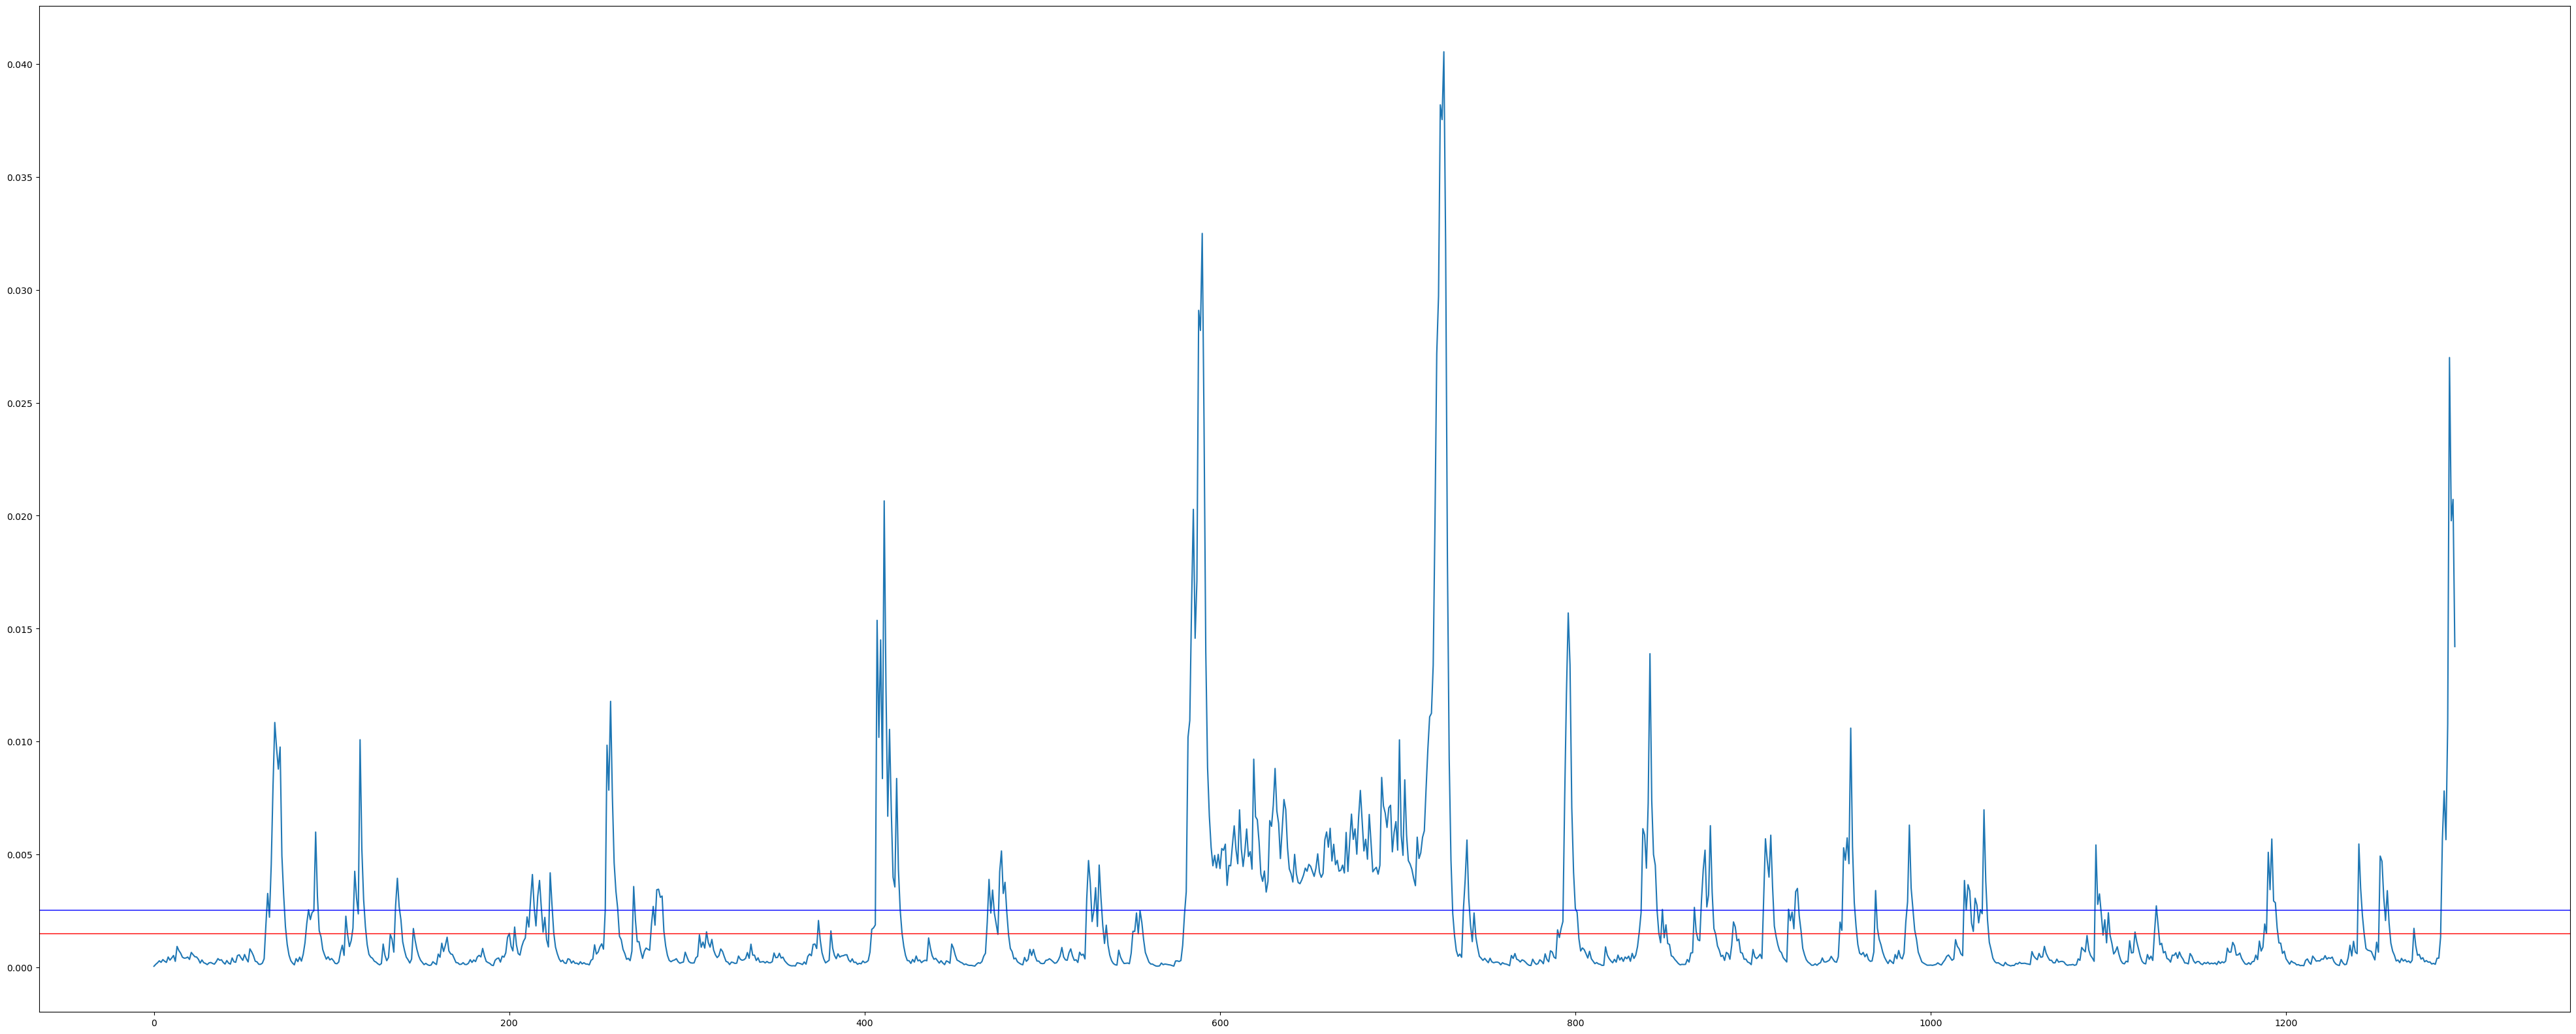

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(1107, 7)
1


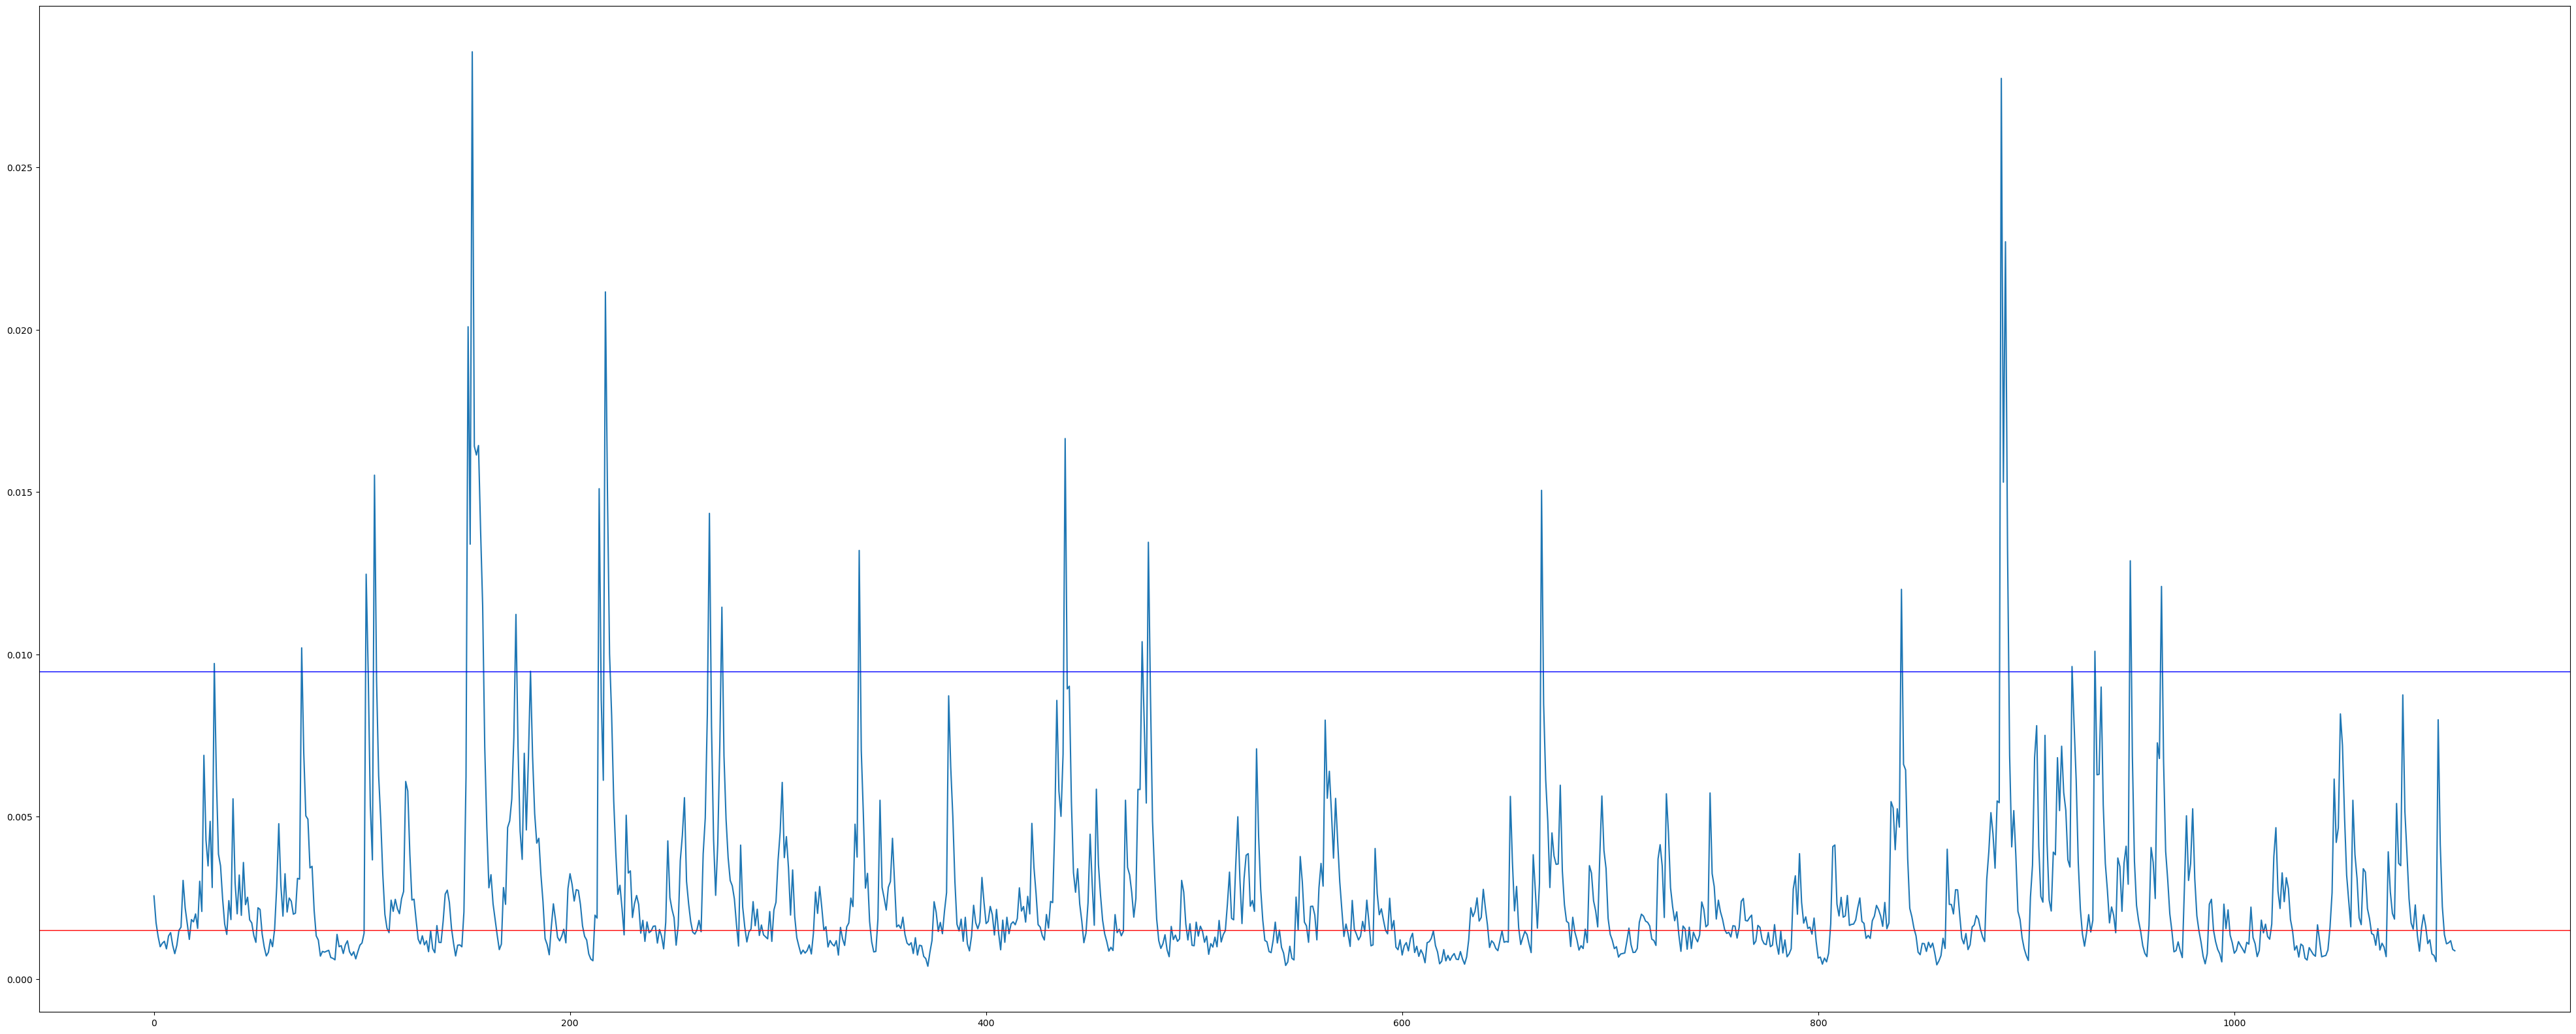

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(1098, 7)
2


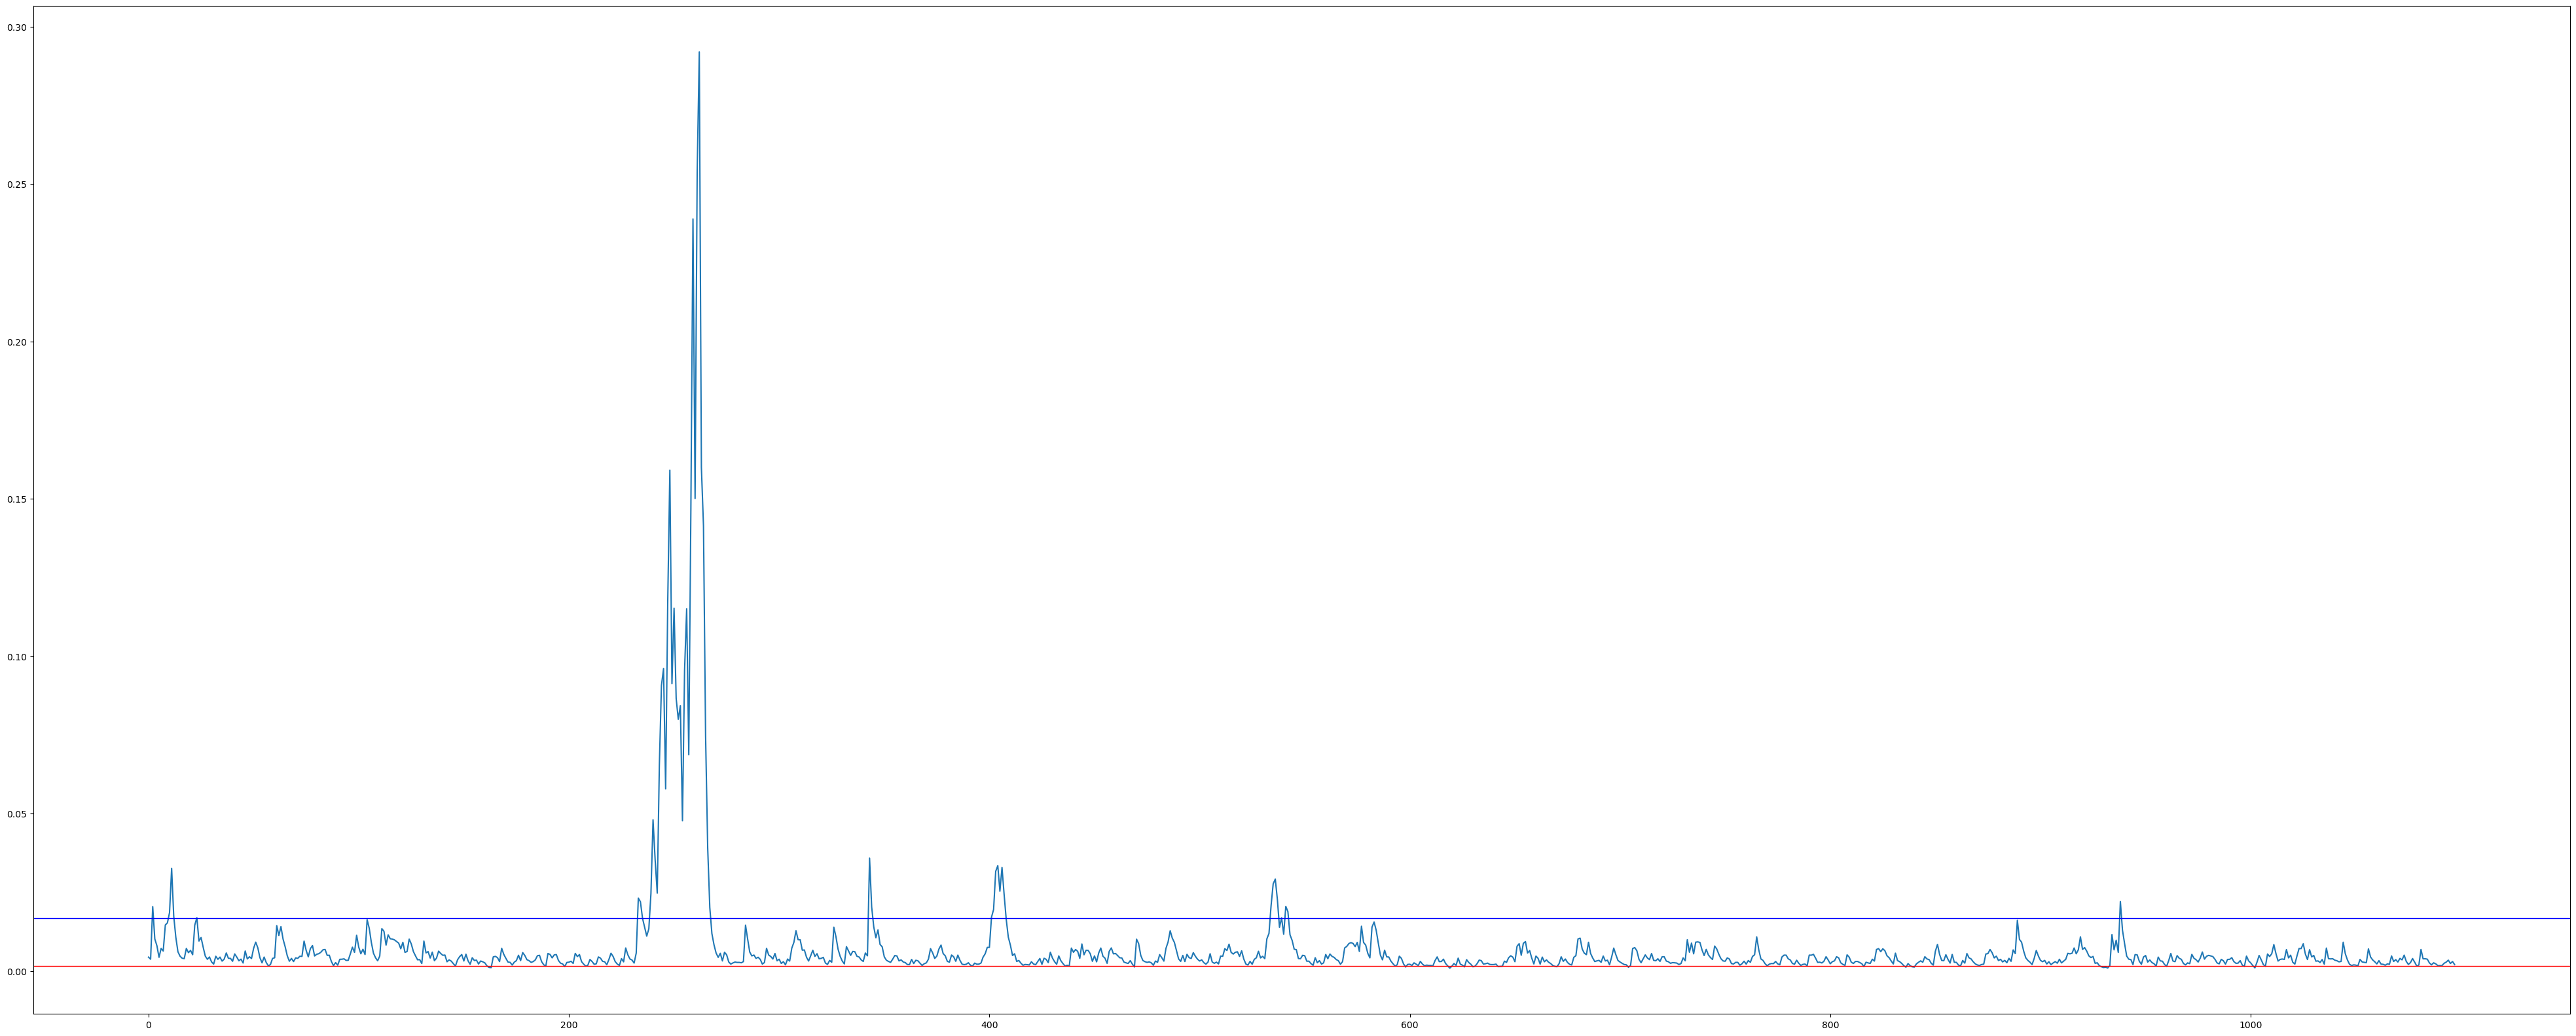

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(918, 7)
3


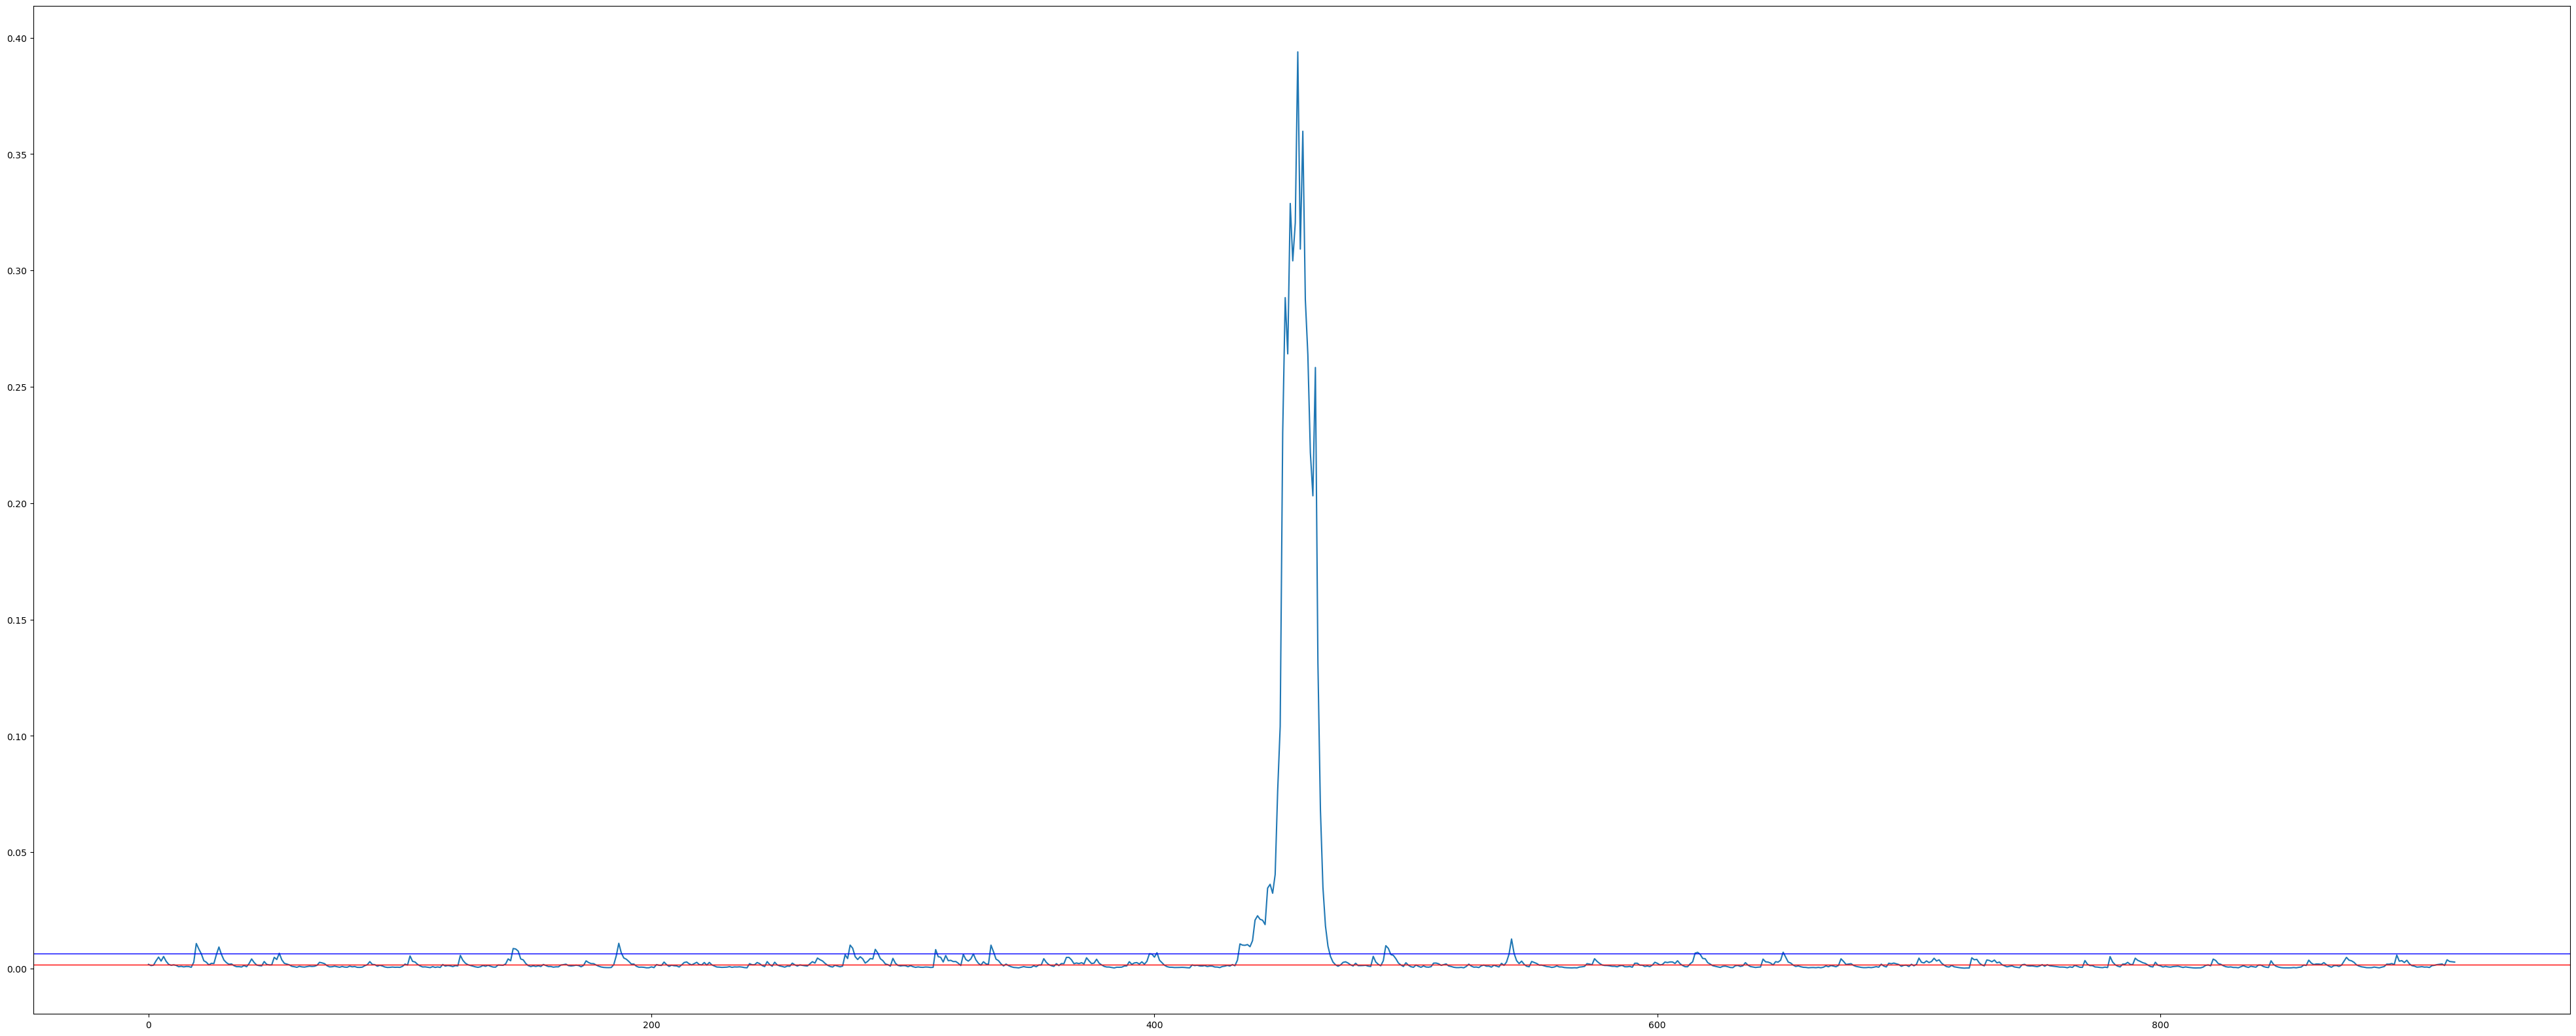

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(918, 7)
4


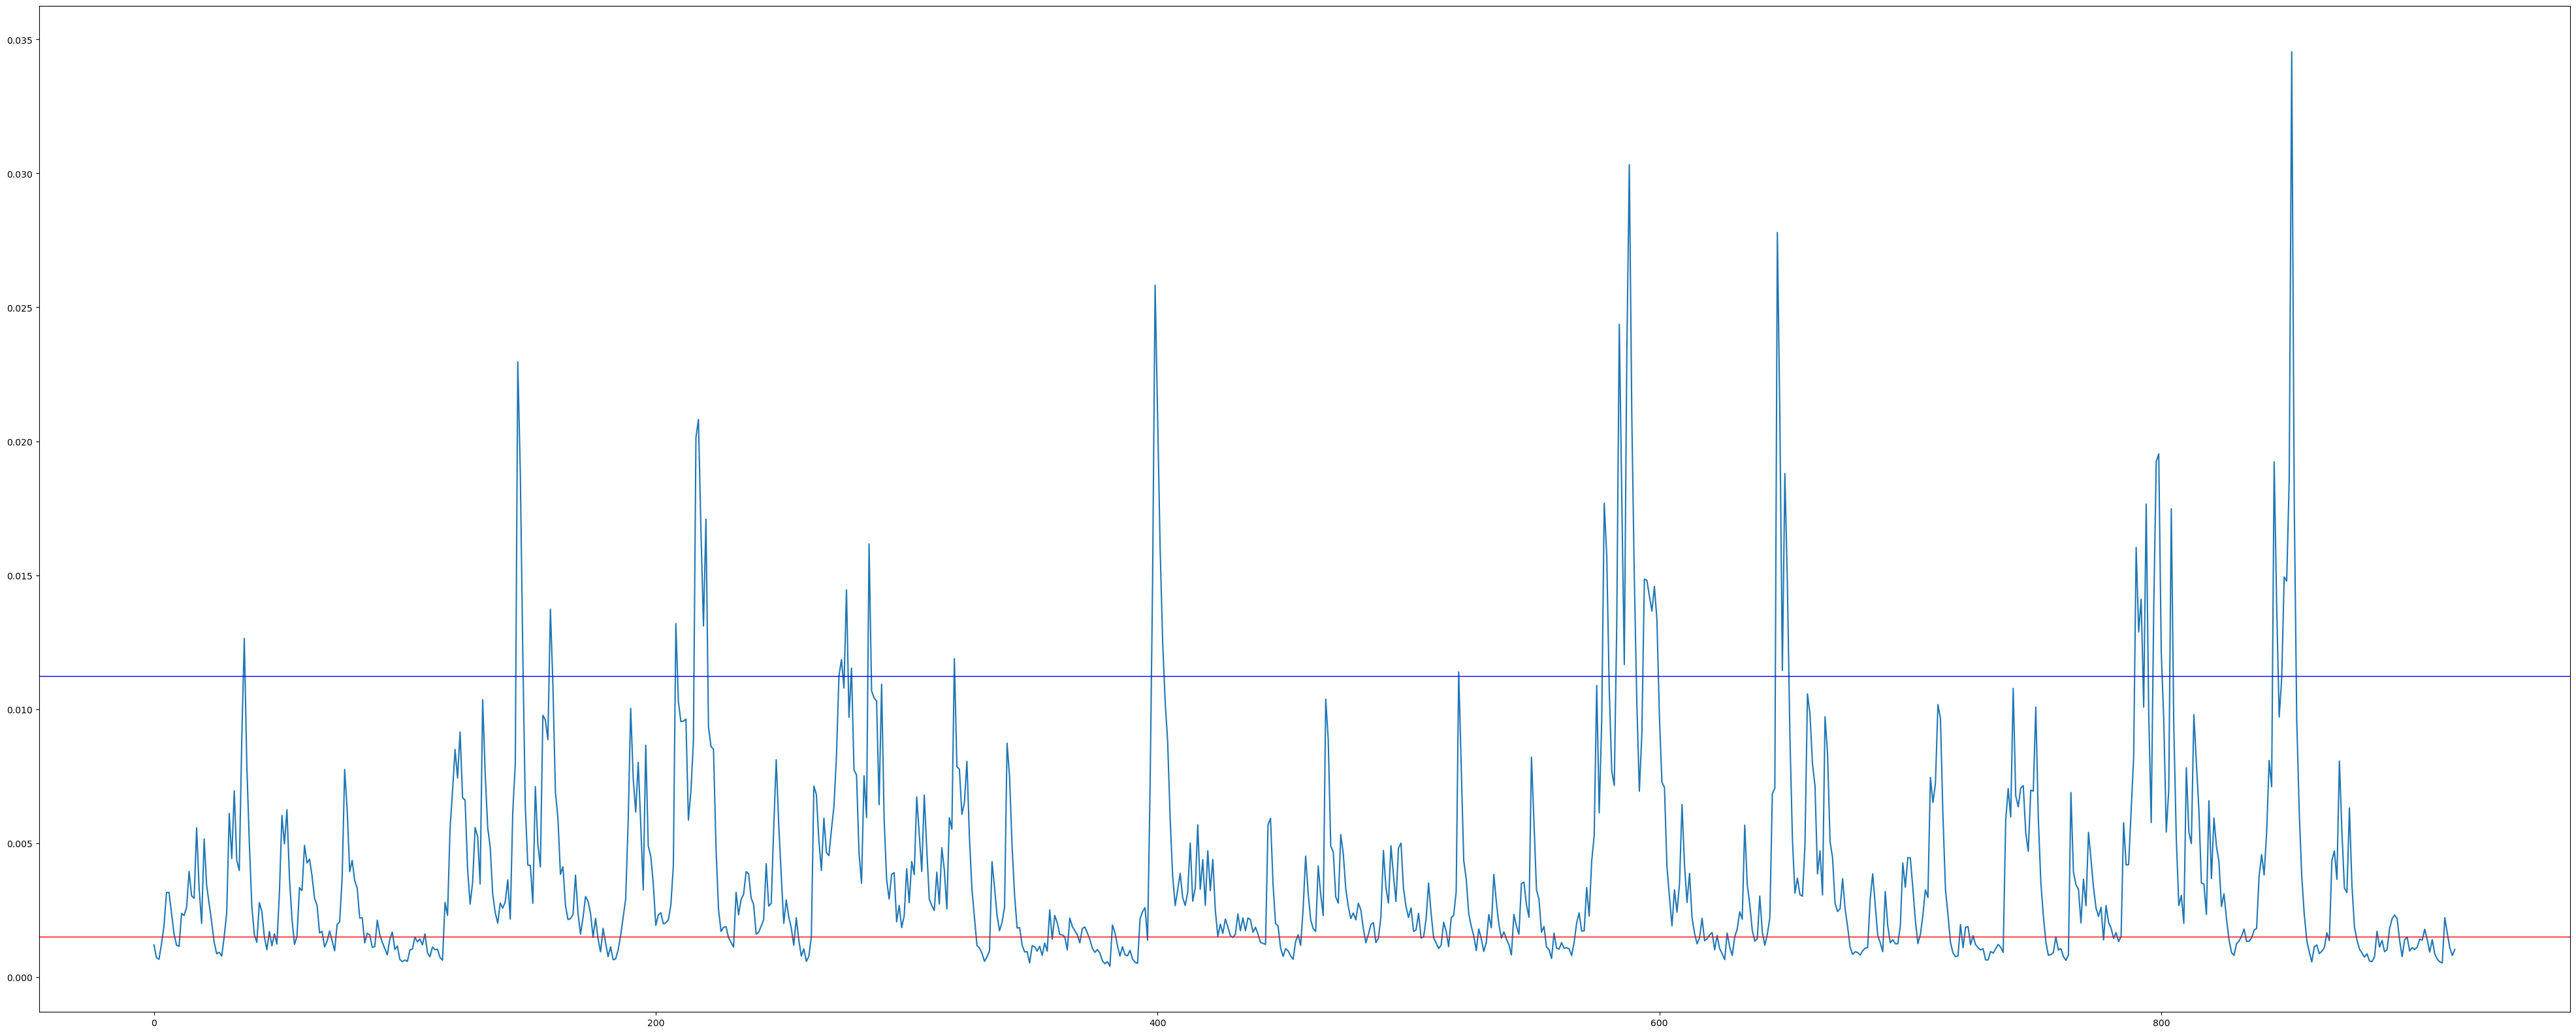

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(747, 7)
5


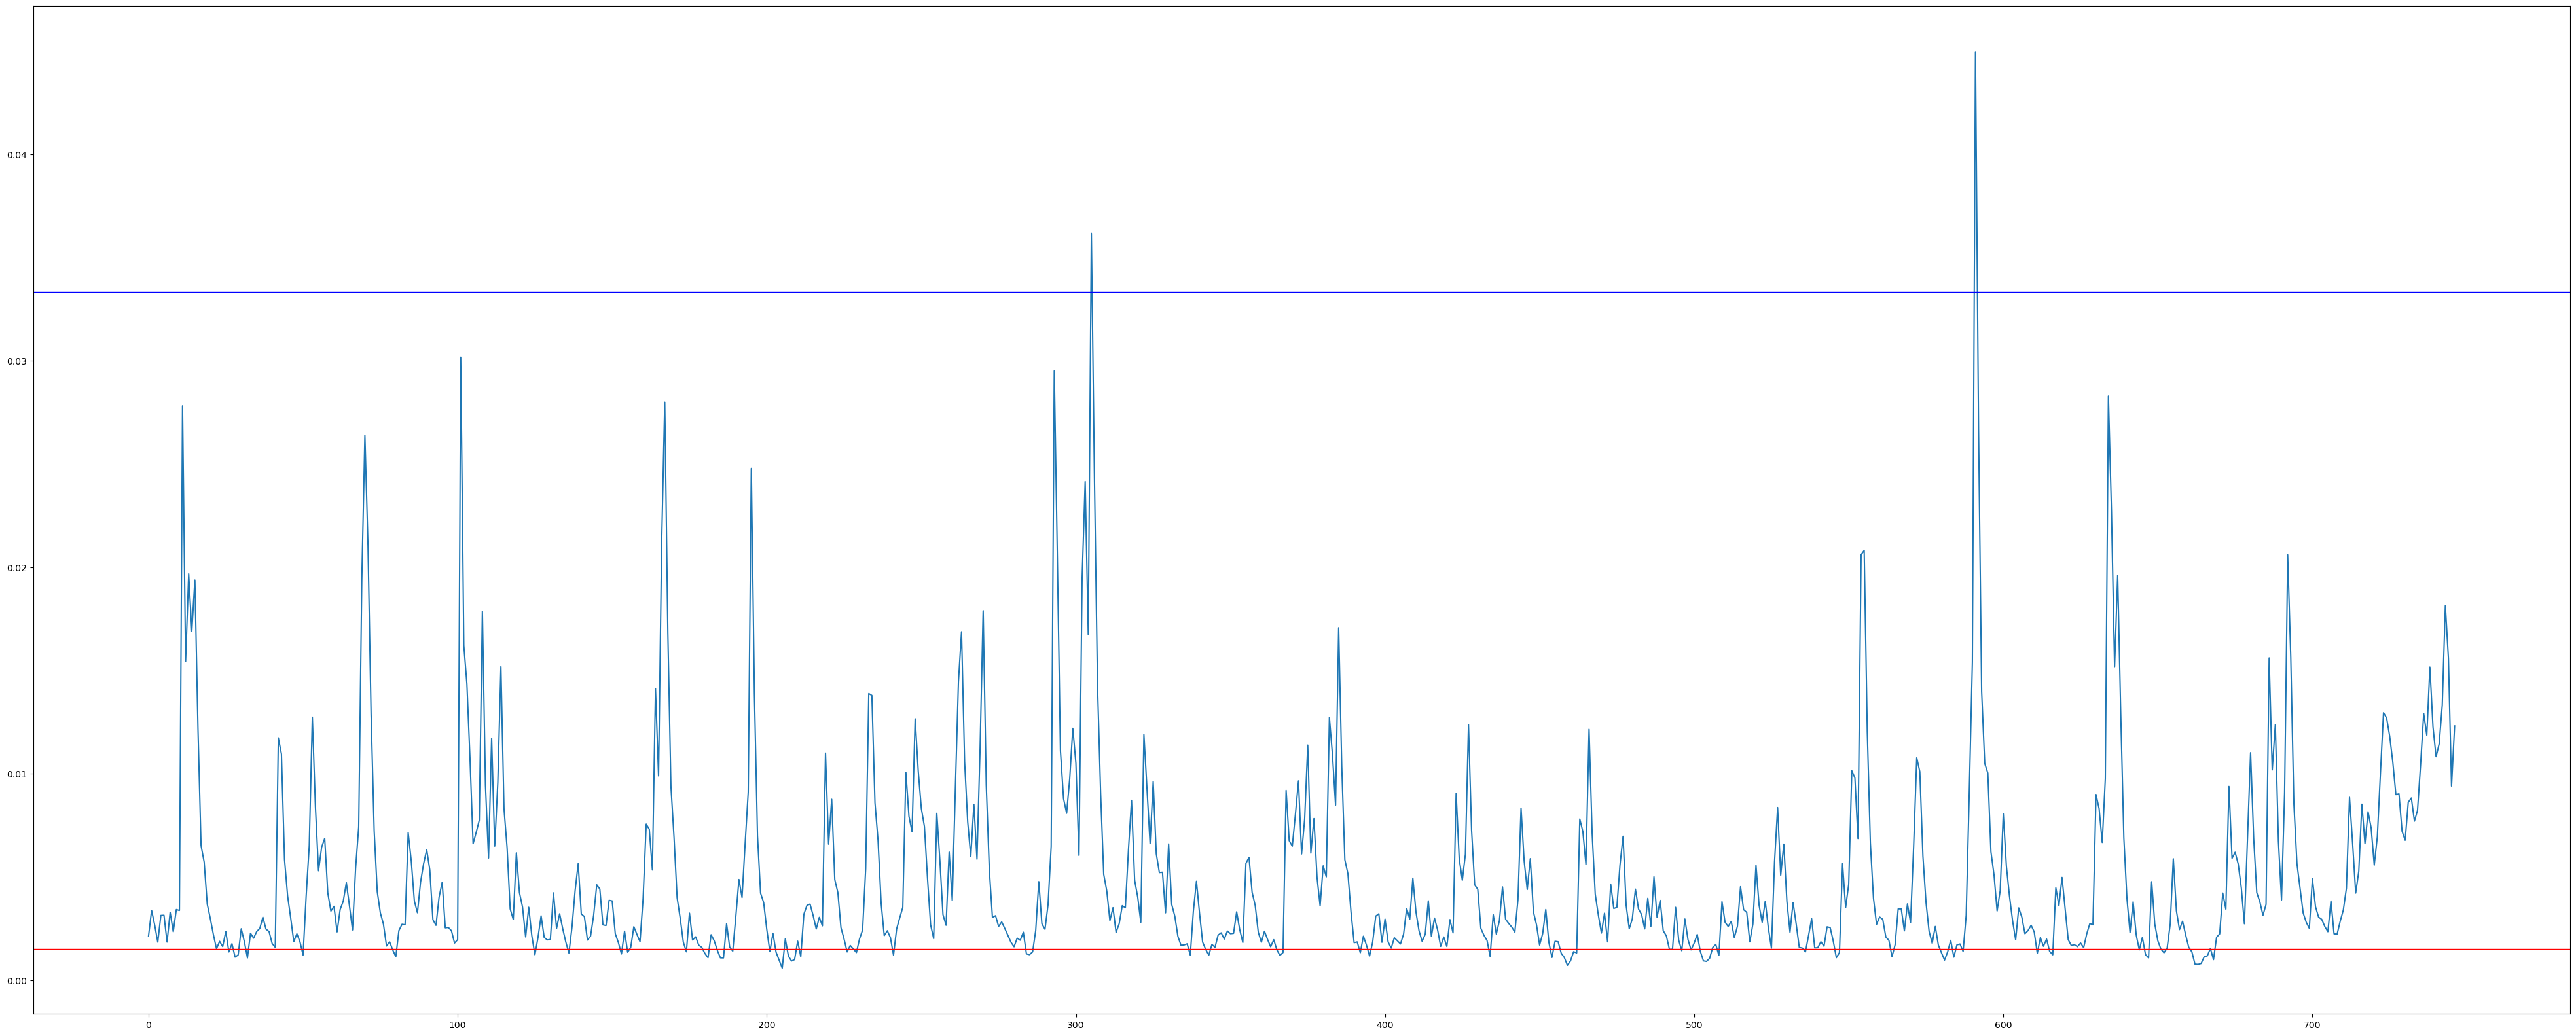

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(747, 7)
6


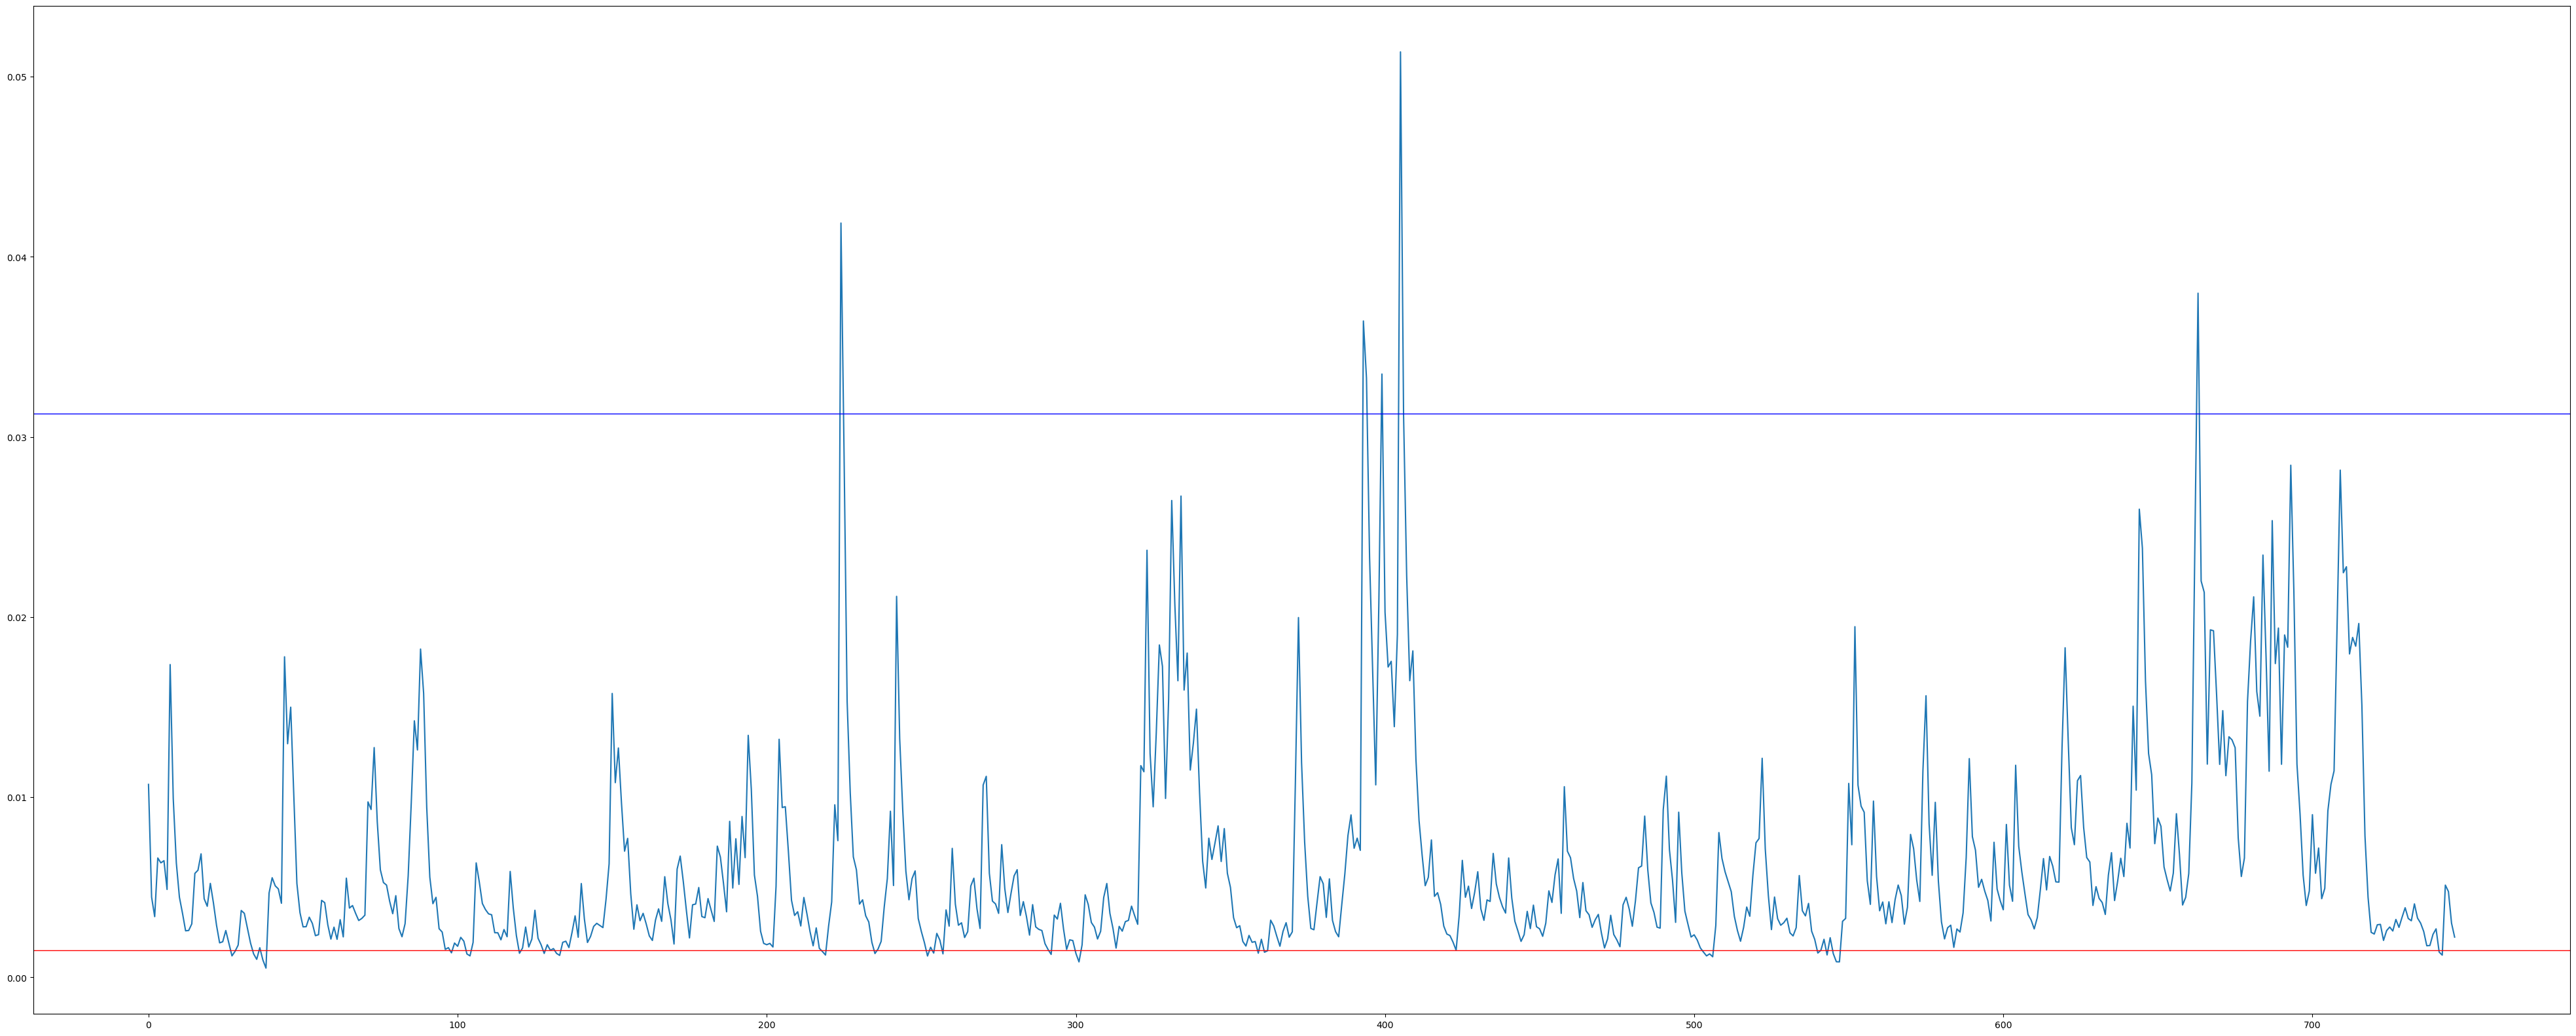

/opt/homebrew/Caskroom/miniforge/base/envs/cain_real/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(558, 7)
7


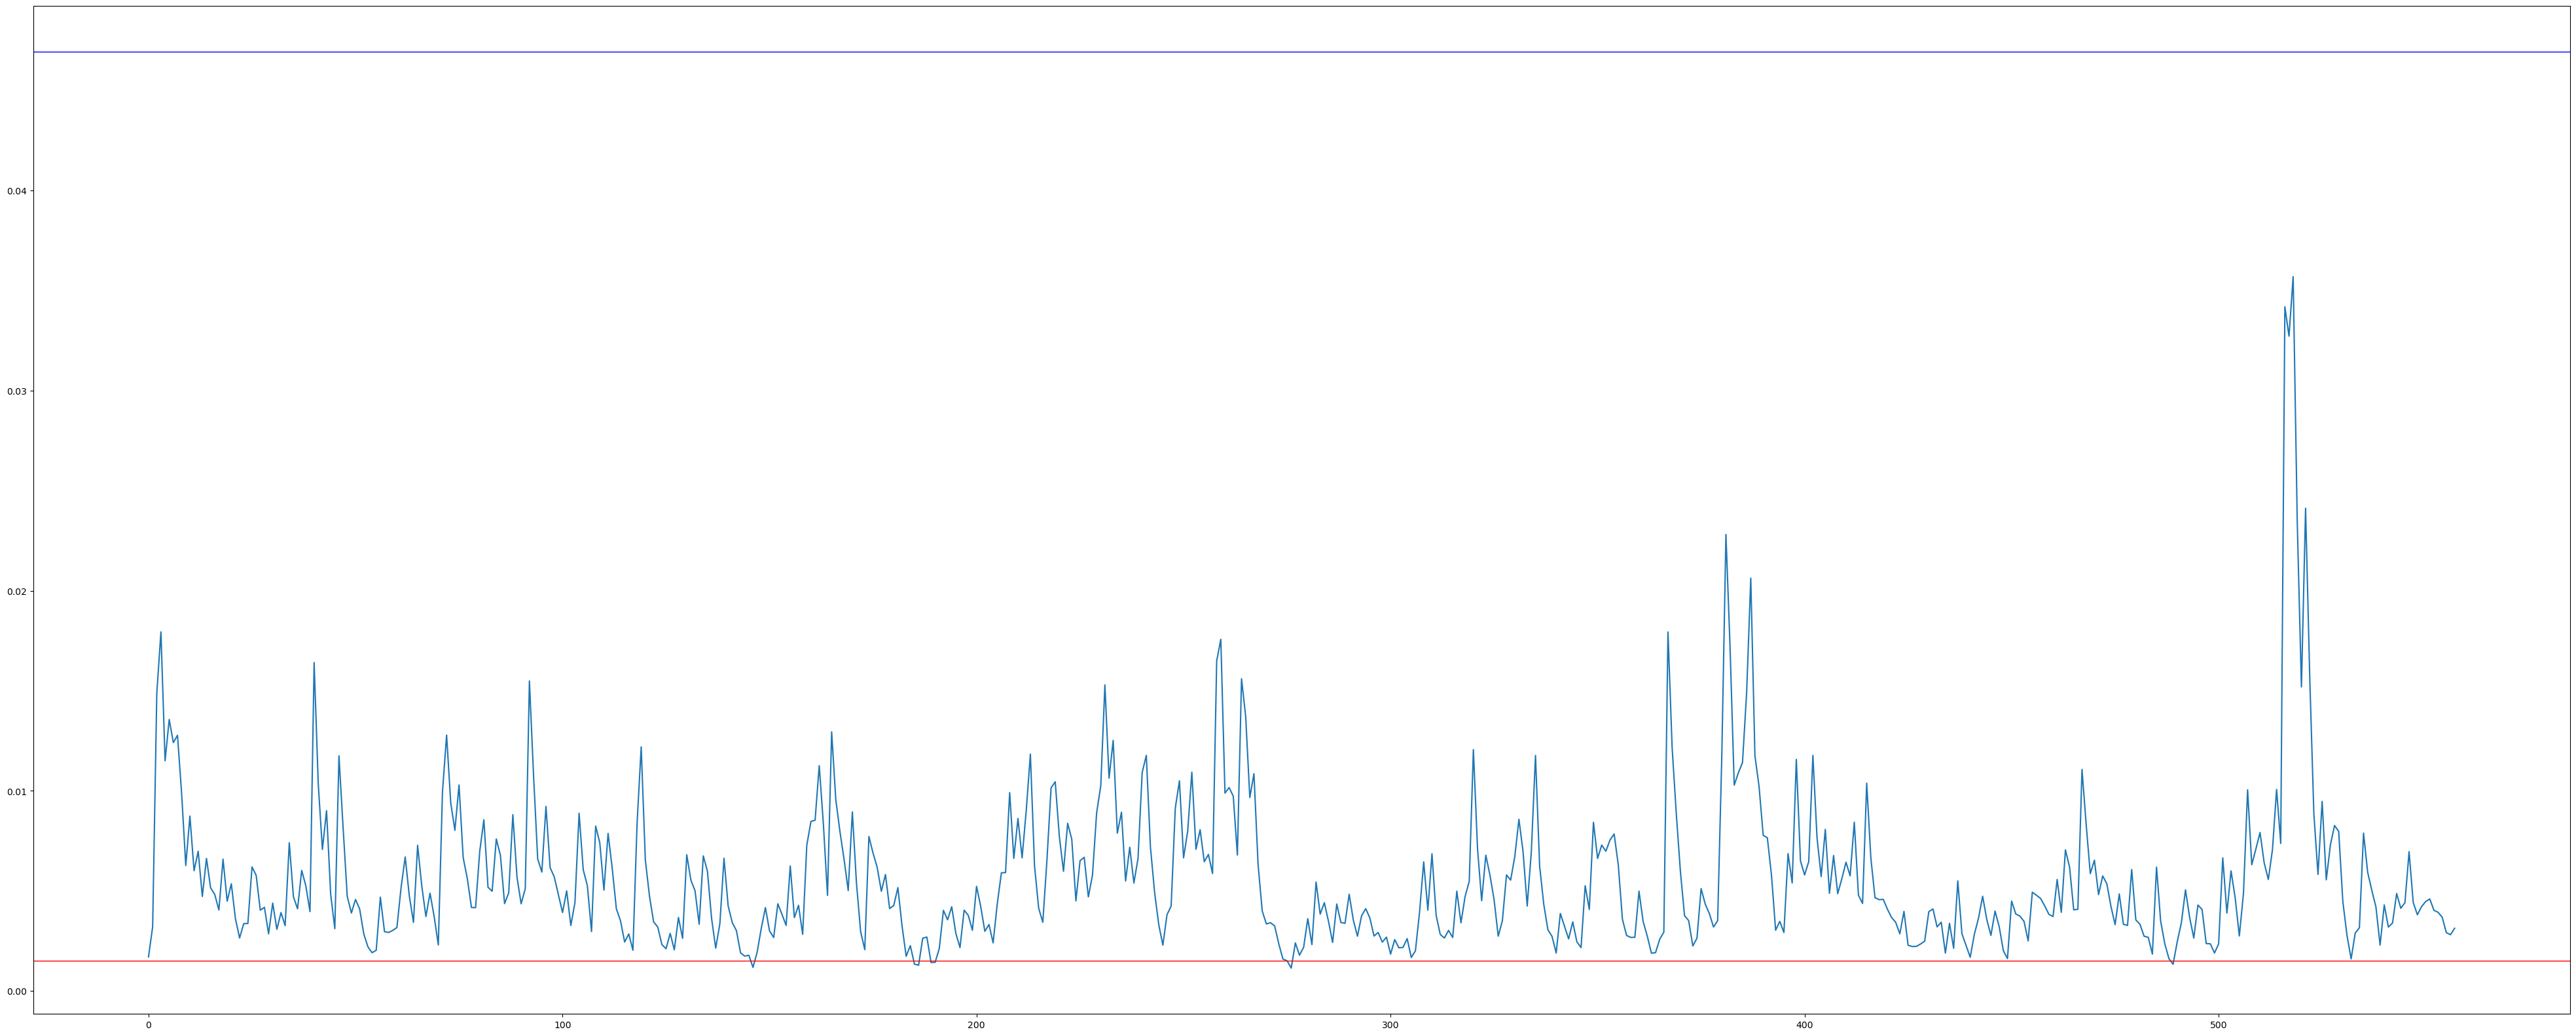

In [21]:
pred = []
#threshold = [0.003, 0.003, 0.003, 0.003, 0.001, 0.003, 0.003, 0.003]
threshold = [0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015]
for i in range(8):
    pretrained_model = torch.load('./' + MODEL_NAME+str(i)+'.pth')
    pretrained_model = pretrained_model.to(device)
    pretrained_model.eval()
    summary(pretrained_model)

    test_type = test_df.loc[test_df['type']==i]
    test_data_drop = test_type.drop('type', axis=1)
    test_x = scaler_list[i].transform(test_data_drop)
    print(test_x.shape)

    test_dataset = MyDataset(making_model_input(test_x))
    test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)
    print(i)
    #print(threshold)
    test_loss = []
    true = []
    pred = []
    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            _x,_ = pretrained_model(x)
            true += x.detach().tolist()
            pred += _x.detach().tolist()
    true_2d = making_2d(true)
    pred_2d = making_2d(pred)
    error = true_2d - pred_2d
    mse_list = np.mean(np.power(error,2),axis=1)
    mse_list = pd.Series(mse_list).ewm(alpha=0.5).mean(10)
    plt.figure(figsize=(50,20))
    plt.plot(mse_list)
    #plt.ylim([0,1])
    plt.axhline(y=threshold[i], color='r', linewidth=1)
    plt.axhline(y=mean_loss_list[i], color='b', linewidth=1)
    plt.show()
    '''mse_arr = torch.tensor(mse_list)
    tmp = torch.where(mse_arr > threshold[i], 1, 0).detach().tolist()
    flag = 0
    
    if len(tmp) > 10:
        for idx in range(len(tmp)-10):
            for k in range(2,10):
                if tmp[idx]==1 and tmp[idx+k]==1:
                    for j in range(1,k):
                        tmp[idx+j] =1
                        
    elif len(tmp) <= 10 and len(tmp) > 2:
         for idx in range(len(tmp)):
            for k in range(2,len(tmp)-idx):
                if tmp[idx]==1 and tmp[idx+k]==1:
                    for j in range(1,k):
                        tmp[idx+j] =1
    
    #warm up
    if len(tmp) > 2:
        for idx in range(2, len(mse_arr)):
            if tmp[idx]==1 and mse_arr[idx-1] > mse_arr[idx-2] and mse_arr[idx-1] > mean_loss_list[i]:
                tmp[idx-1]=1

    #plt.show()
    print(Counter(tmp)) 
    plt.figure(figsize=(50,20))
    plt.plot(tmp)
    plt.show()


    pred += tmp'''


#train start

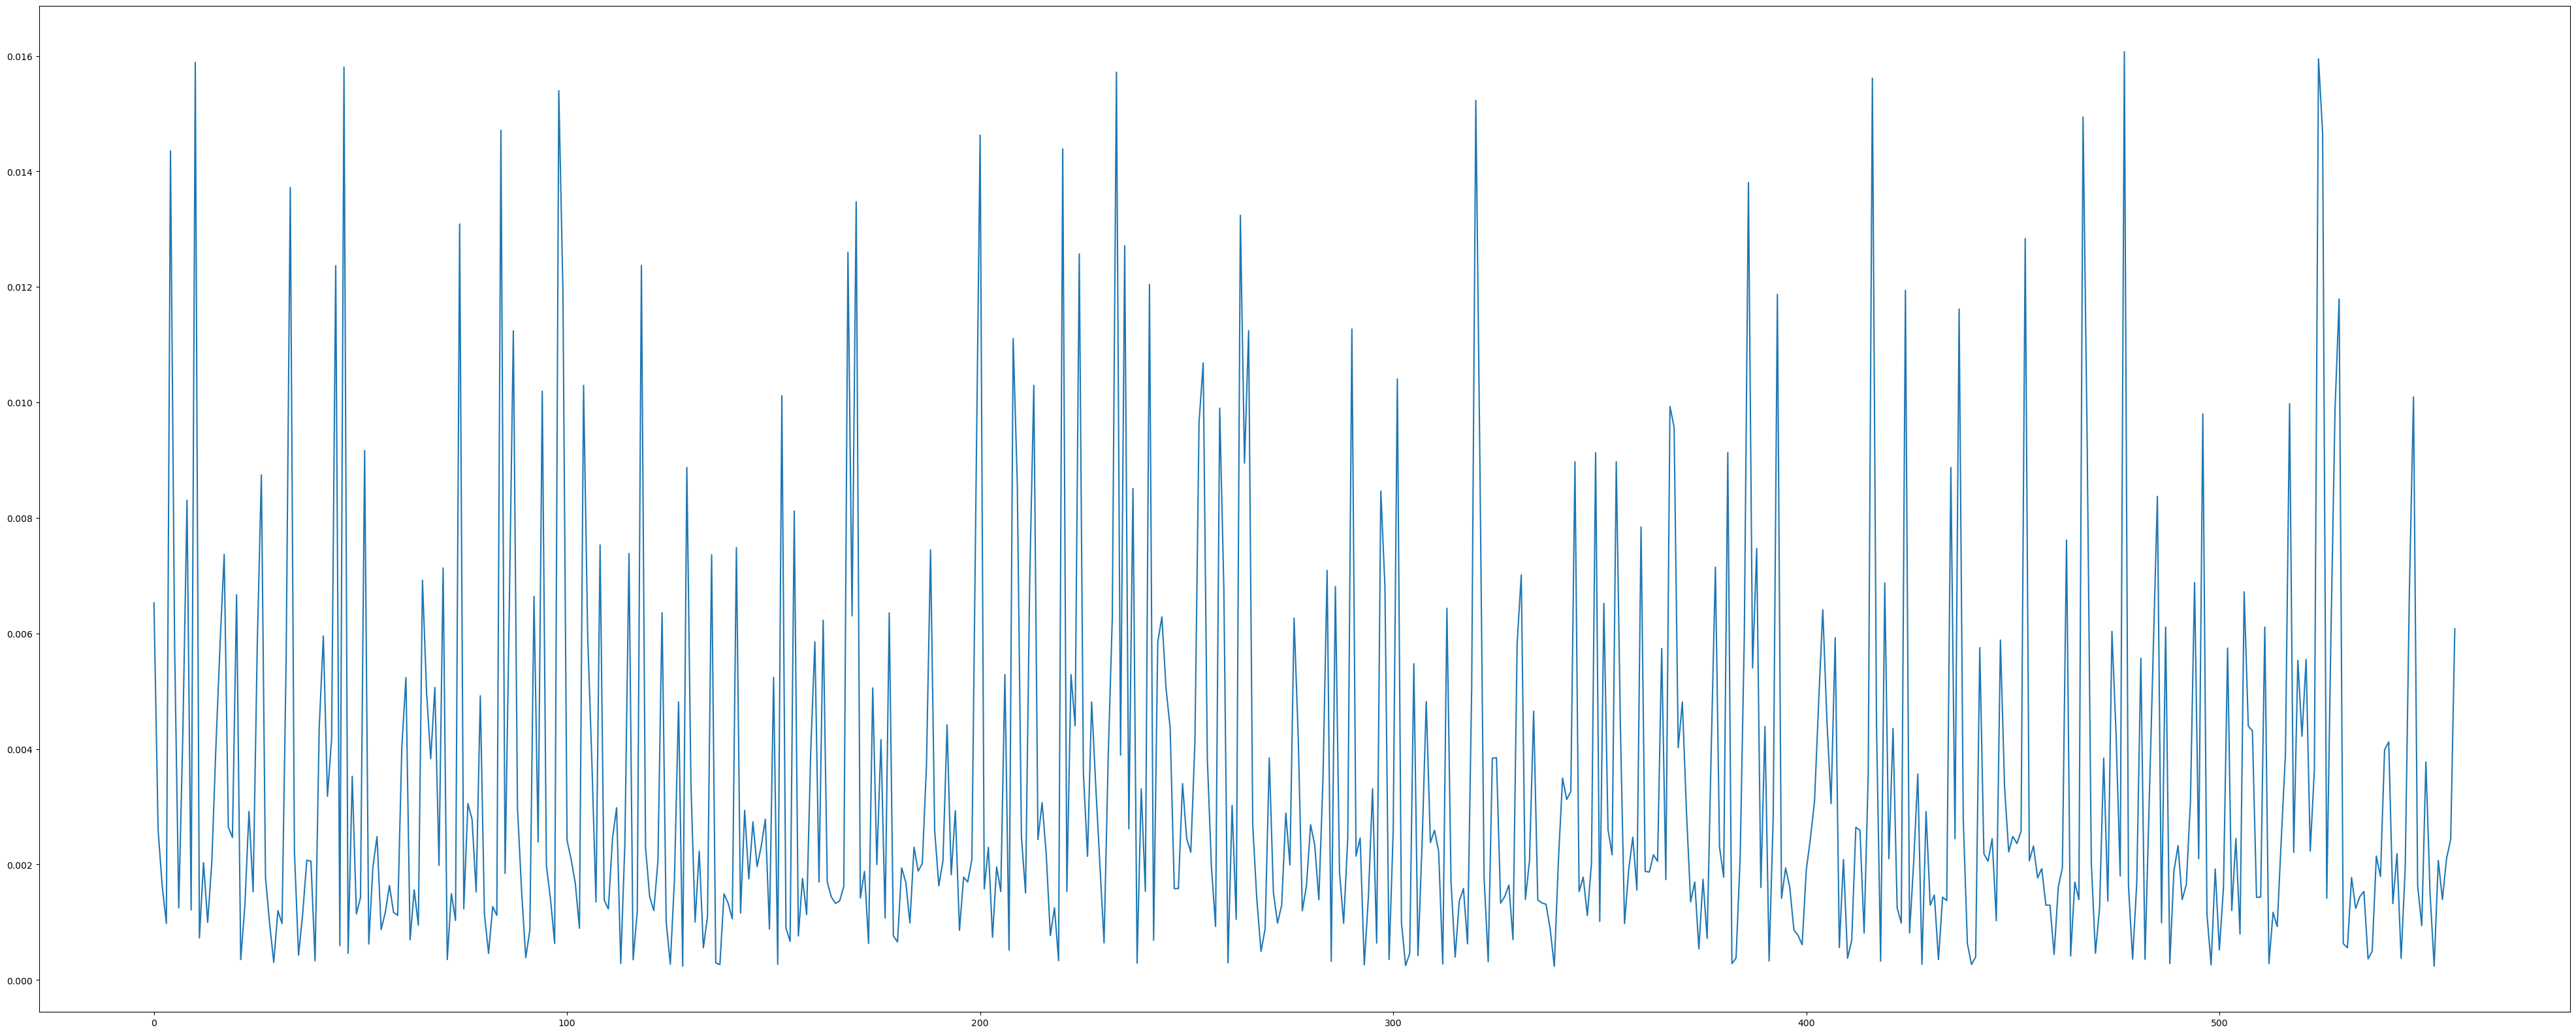

In [431]:
test_loss = []
mse_list = []
with torch.no_grad():
    for x in iter(test_loader):
        x = x.float().to(device)
        _x,_ = pretrained_model(x)
        error = x-_x
        mse = np.mean(np.power(error.numpy(),2),axis=1)
        mse_list.extend(mse)
plt.figure(figsize=(50,20))
plt.plot(mse_list)
plt.show()

for i in range(len(mse_list)):
    if mse_list[i]> 0.03:
        print(mse_list[i])